In [ ]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from torchvision import transforms
from google.colab import drive
from zipfile import ZipFile
from PIL import Image


In [ ]:
import glob
import os
import matplotlib.pyplot as plt
import cv2 as cv
from torch.utils.data import Dataset, DataLoader

import numpy as np
import warnings
warnings.simplefilter('ignore')

In [ ]:
device=torch.device('cuda:0')

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with ZipFile('drive/MyDrive/DUTS-TR.zip', 'r') as Zip:
   # Extract all the contents of zip file in different directory
   Zip.extractall('')

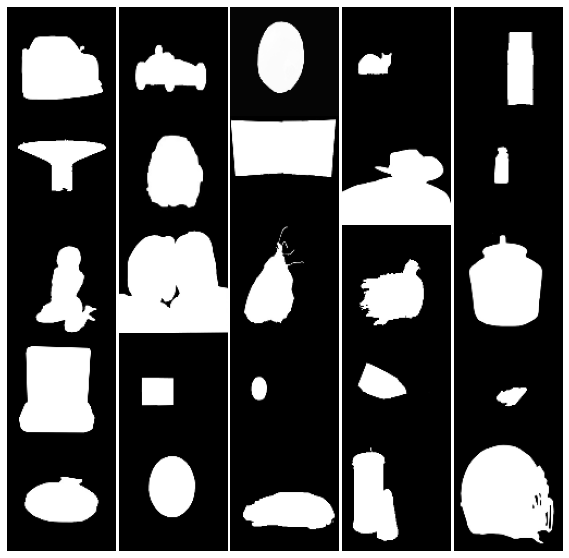

In [ ]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
i_=0
for image in glob.glob('DUTS-TR/DUTS-TR-Mask/*'):
  im = cv.imread(image)
  im = cv.resize(im, (100,100)) 
  plt.subplot(5, 5, i_+1) #.set_title(l)
  plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB)); plt.axis('off')
  i_ += 1
  if i_==25:
    break

In [ ]:
data_dir='/content/DUTS-TR/DUTS-TR-Image'
mask_dir='/content/DUTS-TR/DUTS-TR-Mask'
dataset=os.listdir(data_dir)

In [ ]:
class TRData(Dataset):
  def __init__(self,data,mask):
    self.data=data
    self.mask=mask
    self.dataset=os.listdir(data)
    self.dataset=dataset

  def __len__(self):
    return len(self.dataset)


  def __getitem__(self,index):
    img=Image.open(os.path.join(self.data,dataset[index])).convert('RGB')
    label_path=Image.open(os.path.join(self.mask,dataset[index]).replace('jpg','png')).convert('L')
    pad=max(img.size)
    size=(pad,pad)
    transform = transforms.Compose([
                                    transforms.CenterCrop(size),
                                    transforms.Resize(320),
                                    transforms.ToTensor()
    ])
    image=transform(img)
    label=transform(label_path)
    image=image.permute(1,2,0)
    label=label.permute(1,2,0)
    # print(image.shape,label.shape)
  


    return image.float(),label.float()



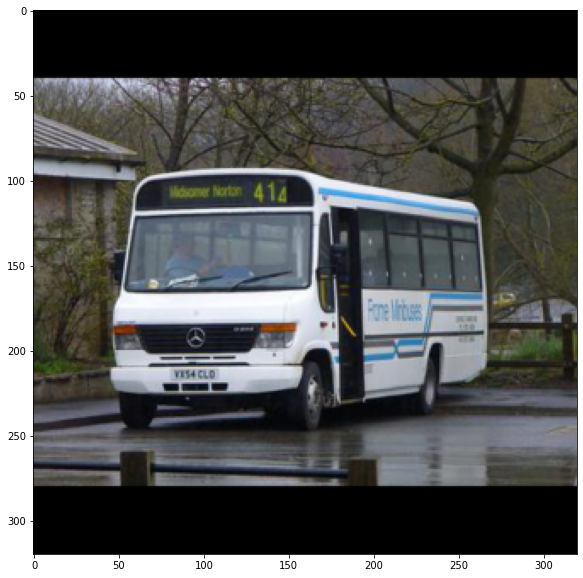

In [ ]:

Data=TRData(data_dir,mask_dir)


plt.imshow(Data.__getitem__(24)[0])

In [ ]:
data_loader=DataLoader(Data,batch_size=10,shuffle=True)


In [ ]:
## U2net is nested Unet where multiple Encoder DEcoder like structures are stacked.
## 6 stages of Encoder and 5 Stages of Decoder
## each Encoder Decoder Box contains Unet architecture,Downsamples and Upsamples Input Image with Skip connections of each stage of Decoder. 
class REBNCONV(nn.Module):
    def __init__(self,in_ch=3,out_ch=3,dirate=1):
        super(REBNCONV,self).__init__()

        self.conv_s1 = nn.Conv2d(in_ch,out_ch,3,padding=1*dirate,dilation=1*dirate)
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self,x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout
# upSamples image to Target Size
#architecture uses Upsample Instead of Deconvolutional layer that is computationally expensive.      
def _upsample_like(src,tar):

    src = F.upsample(src,size=tar.shape[2:],mode='bilinear')

    return src

# The Largest Unet in the ARchitecture. number Coresponds the height of the architecture.
# this is needed to capture information from the biggest Feature Map
# Residual Block Uses Simple Convolutional And max pooling layers, as well as Upsamplig Layers and skip connections
class RSU7(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7,self).__init__()
        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)
        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        #Ceil Mode used instead of Floor Operation while computing the output
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool5 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.rebnconv7 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv6d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)
    def forward(self,x):
        hx = x
        hxin = self.rebnconvin(hx)
        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)
        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)
        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)
        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)
        hx5 = self.rebnconv5(hx)
        hx = self.pool5(hx5)
        hx6 = self.rebnconv6(hx)
        hx7 = self.rebnconv7(hx6)
        hx6d =  self.rebnconv6d(torch.cat((hx7,hx6),1))
        hx6dup = _upsample_like(hx6d,hx5)
        hx5d =  self.rebnconv5d(torch.cat((hx6dup,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)
        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)
        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)
        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)
        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))
        return hx1d + hxin

class RSU6(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6,self).__init__()
        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)
        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x
        hxin = self.rebnconvin(hx)
        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)
        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)
        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)
        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)
        hx5 = self.rebnconv5(hx)
        hx6 = self.rebnconv6(hx5)
        hx5d =  self.rebnconv5d(torch.cat((hx6,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)
        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)
        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)
        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)
        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))
        return hx1d + hxin

class RSU5(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5,self).__init__()
        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)
        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)
    def forward(self,x):
        hx = x
        hxin = self.rebnconvin(hx)
        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)
        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)
        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)
        hx4 = self.rebnconv4(hx)
        hx5 = self.rebnconv5(hx4)
        hx4d = self.rebnconv4d(torch.cat((hx5,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)
        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)
        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)
        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))
        return hx1d + hxin
class RSU4(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4,self).__init__()
        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)
        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):
        hx = x
        hxin = self.rebnconvin(hx)
        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)
        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)
        hx3 = self.rebnconv3(hx)
        hx4 = self.rebnconv4(hx3)
        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)
        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)
        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))
        return hx1d + hxin

#F means that it is a dilated version of RSU.
#instead of pooling layers, there are used Dilated Convolutionals
#Dilated Convolutionals mean that Filters have spaces between cells
# Dilated Convolutionals capture Bigger receptive Field with fewer Layers
# so, with dilated Convolutoinal size of receptive field Grows Exponentialy while number of Parameters grows linearly
# For example, a Dilated Convolutional with 3x3 Kernel and 2 Dilation, will have same receptive filed as 5x5 kernel While using 3x3 kernel Parameters
class RSU4F(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)
        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=4)
        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=8)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x
        hxin = self.rebnconvin(hx)
        hx1 = self.rebnconv1(hxin)
        hx2 = self.rebnconv2(hx1)
        hx3 = self.rebnconv3(hx2)
        hx4 = self.rebnconv4(hx3)
        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx2d = self.rebnconv2d(torch.cat((hx3d,hx2),1))
        hx1d = self.rebnconv1d(torch.cat((hx2d,hx1),1))
        return hx1d + hxin
class U2NETP(nn.Module):

    def __init__(self,in_ch=3,out_ch=1):
        super(U2NETP,self).__init__()

        self.stage1 = RSU7(in_ch,16,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(64,16,64)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(64,16,64)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(64,16,64)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        #The resolution in Encoder 6 and Encoder 5 is low. so we need to use smaller Unet stack for not to lose useful context from the feature map.
        #thats why u2net uses RFU4F
        self.stage5 = RSU4F(64,16,64)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(64,16,64)

        # decoder
        self.stage5d = RSU4F(128,16,64)
        self.stage4d = RSU4(128,16,64)
        self.stage3d = RSU5(128,16,64)
        self.stage2d = RSU6(128,16,64)
        self.stage1d = RSU7(128,16,64)

        self.side1 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side2 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side3 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side4 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side5 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side6 = nn.Conv2d(64,out_ch,3,padding=1)

        self.outconv = nn.Conv2d(6*out_ch,1,1)

    def forward(self,x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6,hx5)

        #decoder
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))

        # U2NET provides six side output probability map from 6 encoder stages. with Sigmoid.
        #so there are 6 Binary output from each decoder stage. 
        #then it upsamples the output to the input image size before concatenates each output and gets final probability map. 
        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d1)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))

        return F.sigmoid(d0), F.sigmoid(d1), F.sigmoid(d2), F.sigmoid(d3), F.sigmoid(d4), F.sigmoid(d5), F.sigmoid(d6)

In [ ]:
model = U2NETP().to(device)
model

U2NETP(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(16, 16, 

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
bce_loss = nn.BCELoss(size_average=True)

def muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, labels_v):

	loss0 = bce_loss(d0,labels_v)
	loss1 = bce_loss(d1,labels_v)
	loss2 = bce_loss(d2,labels_v)
	loss3 = bce_loss(d3,labels_v)
	loss4 = bce_loss(d4,labels_v)
	loss5 = bce_loss(d5,labels_v)
	loss6 = bce_loss(d6,labels_v)

	loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6
	print(f"l0: {loss0.data.item()}, l1: {loss1.data.item()}, l2: {loss2.data.item()}, l3: {loss3.data.item()}, l4: {loss4.data.item()}, l5: {loss5.data.item()}, l6: {loss5.data.item()}\n")

	return loss0, loss

In [ ]:
from tqdm import tqdm


In [ ]:
def train(model,data_loader,optim,loss_f,epochs,path):
  try:
    os.mkdir(path)
  except:
    path=path

  Rloss=0.0
  target_loss=0.0

  for epoch in range(epochs):
    model.train()
    losses=[]
    for step,(X_train,y_train) in tqdm(enumerate(data_loader)):
      step+=1
      X_train,y_train = X_train.to(device),y_train.to(device)
      # y_train= y_train.unsqueeze(0)
      X_train,y_train = X_train.permute(0,3,1,2),y_train.permute(0,3,1,2)
      optim.zero_grad()
      o0,o1,o2,o3,o4,o5,o6 = model(X_train)
      loss2, loss = muti_bce_loss_fusion(o0, o1, o2, o3, o4, o5, o6, y_train)
      loss.backward()
      optim.step()
      Rloss+=loss.data.item()
      target_loss+=loss2.data.item()
      del o0, o1, o2, o3, o4, o5, o6, loss2, loss
      print(f"Epoch : {epoch}, Batch : {step*10}, Loss {Rloss/step},  Target Loss {target_loss/step}")
      if step == 350:
        break
    torch.save(model.state_dict(),f"{path}/model.pt")    
      

In [ ]:
train(model,data_loader,optimizer,bce_loss,1,'models')

0it [00:00, ?it/s]

l0: 0.8489100337028503, l1: 0.7719424366950989, l2: 0.864255428314209, l3: 0.9303351044654846, l4: 0.5113946199417114, l5: 0.8230034708976746, l6: 0.8230034708976746



1it [00:08,  8.02s/it]

Epoch : 0, Batch : 10, Loss 5.513729095458984,  Target Loss 0.8489100337028503
l0: 0.7612317204475403, l1: 0.7149702310562134, l2: 0.7520514130592346, l3: 0.7606880068778992, l4: 0.4866214692592621, l5: 0.6815705895423889, l6: 0.6815705895423889



2it [00:15,  7.81s/it]

Epoch : 0, Batch : 20, Loss 5.1431334018707275,  Target Loss 0.8050708770751953
l0: 0.6182034015655518, l1: 0.5726032853126526, l2: 0.6033064126968384, l3: 0.5983754992485046, l4: 0.4730110168457031, l5: 0.546029806137085, l6: 0.546029806137085



3it [00:23,  7.74s/it]

Epoch : 0, Batch : 30, Loss 4.744536717732747,  Target Loss 0.7427817185719808
l0: 0.536125659942627, l1: 0.5006642937660217, l2: 0.5131151080131531, l3: 0.5344631671905518, l4: 0.47598472237586975, l5: 0.4688827097415924, l6: 0.4688827097415924



4it [00:30,  7.71s/it]

Epoch : 0, Batch : 40, Loss 4.442777991294861,  Target Loss 0.6911177039146423
l0: 0.43783894181251526, l1: 0.3901596963405609, l2: 0.4146382510662079, l3: 0.42738136649131775, l4: 0.3521174192428589, l5: 0.3789125382900238, l6: 0.3789125382900238



5it [00:38,  7.69s/it]

Epoch : 0, Batch : 50, Loss 4.1180095195770265,  Target Loss 0.6404619514942169
l0: 0.38194960355758667, l1: 0.36626094579696655, l2: 0.3917708396911621, l3: 0.3776131868362427, l4: 0.32873401045799255, l5: 0.3326698839664459, l6: 0.3326698839664459



6it [00:46,  7.68s/it]

Epoch : 0, Batch : 60, Loss 3.8586552143096924,  Target Loss 0.5973765601714452
l0: 0.3446125090122223, l1: 0.34372663497924805, l2: 0.36196768283843994, l3: 0.3610020875930786, l4: 0.3065778315067291, l5: 0.3202807307243347, l6: 0.3202807307243347



7it [00:53,  7.67s/it]

Epoch : 0, Batch : 70, Loss 3.651524237224034,  Target Loss 0.5612674100058419
l0: 0.3862040042877197, l1: 0.47587883472442627, l2: 0.41141000390052795, l3: 0.402070015668869, l4: 0.3540060520172119, l5: 0.3539145588874817, l6: 0.3539145588874817



8it [01:01,  7.67s/it]

Epoch : 0, Batch : 80, Loss 3.5418494641780853,  Target Loss 0.5393844842910767
l0: 0.3235723376274109, l1: 0.3618021011352539, l2: 0.3564305603504181, l3: 0.36322057247161865, l4: 0.3202149271965027, l5: 0.3363538086414337, l6: 0.3363538086414337



9it [01:09,  7.67s/it]

Epoch : 0, Batch : 90, Loss 3.418434249030219,  Target Loss 0.5154053568840027
l0: 0.38667169213294983, l1: 0.4463772177696228, l2: 0.4276043772697449, l3: 0.4304299056529999, l4: 0.4111248850822449, l5: 0.4072990119457245, l6: 0.4072990119457245



10it [01:17,  7.68s/it]

Epoch : 0, Batch : 100, Loss 3.368849015235901,  Target Loss 0.5025319904088974
l0: 0.36493661999702454, l1: 0.3867356777191162, l2: 0.37906527519226074, l3: 0.37469691038131714, l4: 0.39228230714797974, l5: 0.37894973158836365, l6: 0.37894973158836365



11it [01:24,  7.67s/it]

Epoch : 0, Batch : 110, Loss 3.3050231716849585,  Target Loss 0.4900233203714544
l0: 0.3814195692539215, l1: 0.4108487069606781, l2: 0.3924156129360199, l3: 0.41521647572517395, l4: 0.3815714418888092, l5: 0.3918425738811493, l6: 0.3918425738811493



12it [01:32,  7.67s/it]

Epoch : 0, Batch : 120, Loss 3.2583192586898804,  Target Loss 0.4809730077783267
l0: 0.3133321702480316, l1: 0.3277943432331085, l2: 0.3218057453632355, l3: 0.34232988953590393, l4: 0.3175613284111023, l5: 0.3211815357208252, l6: 0.3211815357208252



13it [01:39,  7.67s/it]

Epoch : 0, Batch : 130, Loss 3.184997870371892,  Target Loss 0.46807755873753476
l0: 0.41377198696136475, l1: 0.41506966948509216, l2: 0.4109594225883484, l3: 0.4278022348880768, l4: 0.44179049134254456, l5: 0.4244668781757355, l6: 0.4244668781757355



14it [01:47,  7.67s/it]

Epoch : 0, Batch : 140, Loss 3.166109459740775,  Target Loss 0.46419858932495117
l0: 0.30494609475135803, l1: 0.3006577491760254, l2: 0.28630489110946655, l3: 0.2861630320549011, l4: 0.29233530163764954, l5: 0.265101820230484, l6: 0.265101820230484



15it [01:55,  7.67s/it]

Epoch : 0, Batch : 150, Loss 3.0908044815063476,  Target Loss 0.4535817563533783
l0: 0.31959936022758484, l1: 0.33098793029785156, l2: 0.3430793583393097, l3: 0.3154602348804474, l4: 0.31880122423171997, l5: 0.30617061257362366, l6: 0.30617061257362366



16it [02:03,  7.68s/it]

Epoch : 0, Batch : 160, Loss 3.038888081908226,  Target Loss 0.4452078565955162
l0: 0.3201267719268799, l1: 0.3263311982154846, l2: 0.33462509512901306, l3: 0.32148444652557373, l4: 0.3203817903995514, l5: 0.3176123797893524, l6: 0.3176123797893524



17it [02:10,  7.67s/it]

Epoch : 0, Batch : 170, Loss 2.993799125446993,  Target Loss 0.43785014573265524
l0: 0.3528556525707245, l1: 0.35871922969818115, l2: 0.3734540641307831, l3: 0.36935552954673767, l4: 0.3645825982093811, l5: 0.37982335686683655, l6: 0.37982335686683655



18it [02:18,  7.67s/it]

Epoch : 0, Batch : 180, Loss 2.971058792538113,  Target Loss 0.4331282294458813
l0: 0.2983208894729614, l1: 0.27587127685546875, l2: 0.2777568995952606, l3: 0.289013147354126, l4: 0.2889452874660492, l5: 0.2925058603286743, l6: 0.2925058603286743



19it [02:26,  7.67s/it]

Epoch : 0, Batch : 190, Loss 2.921222071898611,  Target Loss 0.4260331062894118
l0: 0.2964599132537842, l1: 0.28256502747535706, l2: 0.2796669602394104, l3: 0.27606675028800964, l4: 0.29366347193717957, l5: 0.3123246431350708, l6: 0.3123246431350708



20it [02:33,  7.68s/it]

Epoch : 0, Batch : 200, Loss 2.8770828247070312,  Target Loss 0.4195544466376305
l0: 0.33984309434890747, l1: 0.34743091464042664, l2: 0.3479626774787903, l3: 0.34516653418540955, l4: 0.35955455899238586, l5: 0.359671026468277, l6: 0.359671026468277



21it [02:41,  7.67s/it]

Epoch : 0, Batch : 210, Loss 2.8562521707443964,  Target Loss 0.41575866795721506
l0: 0.3431415259838104, l1: 0.328547865152359, l2: 0.35416921973228455, l3: 0.36635980010032654, l4: 0.3978079855442047, l5: 0.42490482330322266, l6: 0.42490482330322266



22it [02:49,  7.67s/it]

Epoch : 0, Batch : 220, Loss 2.8447463404048574,  Target Loss 0.4124578887766058
l0: 0.38255301117897034, l1: 0.4361175000667572, l2: 0.4293037950992584, l3: 0.4011908769607544, l4: 0.3961140513420105, l5: 0.4358668029308319, l6: 0.4358668029308319



23it [02:56,  7.67s/it]

Epoch : 0, Batch : 230, Loss 2.8469119901242466,  Target Loss 0.41115767670714337
l0: 0.3405839204788208, l1: 0.3647136390209198, l2: 0.36144953966140747, l3: 0.3438479006290436, l4: 0.31703847646713257, l5: 0.33861243724823, l6: 0.33861243724823



24it [03:04,  7.67s/it]

Epoch : 0, Batch : 240, Loss 2.828406115372976,  Target Loss 0.40821710353096324
l0: 0.3288617730140686, l1: 0.36058276891708374, l2: 0.3231726586818695, l3: 0.3215041756629944, l4: 0.31929540634155273, l5: 0.3119635283946991, l6: 0.3119635283946991



25it [03:12,  7.67s/it]

Epoch : 0, Batch : 250, Loss 2.806652097702026,  Target Loss 0.40504289031028745
l0: 0.3228282332420349, l1: 0.3305773437023163, l2: 0.3164275586605072, l3: 0.3314022123813629, l4: 0.33197617530822754, l5: 0.30197668075561523, l6: 0.30197668075561523



26it [03:19,  7.67s/it]

Epoch : 0, Batch : 260, Loss 2.785055105502789,  Target Loss 0.40188078811535466
l0: 0.34763509035110474, l1: 0.33235663175582886, l2: 0.33665138483047485, l3: 0.3344409465789795, l4: 0.3626076877117157, l5: 0.3216390013694763, l6: 0.3216390013694763



27it [03:27,  7.68s/it]

Epoch : 0, Batch : 270, Loss 2.768635635022764,  Target Loss 0.39987168819816027
l0: 0.325998991727829, l1: 0.32072487473487854, l2: 0.33074039220809937, l3: 0.33070164918899536, l4: 0.3331032693386078, l5: 0.3449857532978058, l6: 0.3449857532978058



28it [03:35,  7.67s/it]

Epoch : 0, Batch : 280, Loss 2.7527797988482883,  Target Loss 0.3972333776099341
l0: 0.29373908042907715, l1: 0.2792593538761139, l2: 0.28745198249816895, l3: 0.2839967906475067, l4: 0.2996702492237091, l5: 0.29692232608795166, l6: 0.29692232608795166



29it [03:42,  7.68s/it]

Epoch : 0, Batch : 290, Loss 2.728157035235701,  Target Loss 0.39366460874162873
l0: 0.3115098178386688, l1: 0.29732656478881836, l2: 0.3026617467403412, l3: 0.28445619344711304, l4: 0.3091440796852112, l5: 0.29846498370170593, l6: 0.29846498370170593



30it [03:50,  7.67s/it]

Epoch : 0, Batch : 300, Loss 2.7077236731847125,  Target Loss 0.3909261157115301
l0: 0.31480807065963745, l1: 0.31003400683403015, l2: 0.3056524693965912, l3: 0.30059319734573364, l4: 0.29728034138679504, l5: 0.31003451347351074, l6: 0.31003451347351074



31it [03:58,  7.67s/it]

Epoch : 0, Batch : 310, Loss 2.6902032129226194,  Target Loss 0.38847069490340447
l0: 0.3205011188983917, l1: 0.31745123863220215, l2: 0.31503474712371826, l3: 0.3112344741821289, l4: 0.3088204264640808, l5: 0.3103427290916443, l6: 0.3103427290916443



32it [04:05,  7.68s/it]

Epoch : 0, Batch : 320, Loss 2.6741146072745323,  Target Loss 0.38634664565324783
l0: 0.2758015990257263, l1: 0.2685569226741791, l2: 0.2615535259246826, l3: 0.26572948694229126, l4: 0.2799206078052521, l5: 0.2903749346733093, l6: 0.2903749346733093



33it [04:13,  7.68s/it]

Epoch : 0, Batch : 330, Loss 2.6516463395321006,  Target Loss 0.38299679575544415
l0: 0.31296271085739136, l1: 0.32726526260375977, l2: 0.3328528106212616, l3: 0.3251004219055176, l4: 0.33368778228759766, l5: 0.32206422090530396, l6: 0.32206422090530396



34it [04:21,  7.68s/it]

Epoch : 0, Batch : 340, Loss 2.6410340842078712,  Target Loss 0.38093696972903085
l0: 0.32703137397766113, l1: 0.33589625358581543, l2: 0.3306027352809906, l3: 0.32819169759750366, l4: 0.3451785147190094, l5: 0.33084797859191895, l6: 0.33084797859191895



35it [04:28,  7.68s/it]

Epoch : 0, Batch : 350, Loss 2.631857558659145,  Target Loss 0.3793968098504203
l0: 0.361857146024704, l1: 0.36478883028030396, l2: 0.3661714792251587, l3: 0.34519070386886597, l4: 0.3944597542285919, l5: 0.4288922846317291, l6: 0.4288922846317291



36it [04:36,  7.68s/it]

Epoch : 0, Batch : 360, Loss 2.6321974794069924,  Target Loss 0.3789095969663726
l0: 0.25754761695861816, l1: 0.2478354573249817, l2: 0.242431178689003, l3: 0.24656763672828674, l4: 0.24283866584300995, l5: 0.2544545531272888, l6: 0.2544545531272888



37it [04:44,  7.68s/it]

Epoch : 0, Batch : 370, Loss 2.6086196448351884,  Target Loss 0.3756295434526495
l0: 0.2791729271411896, l1: 0.2626480162143707, l2: 0.2651272714138031, l3: 0.261721134185791, l4: 0.27715760469436646, l5: 0.2992589473724365, l6: 0.2992589473724365



38it [04:51,  7.67s/it]

Epoch : 0, Batch : 380, Loss 2.590554902428075,  Target Loss 0.3730912114444532
l0: 0.2967773973941803, l1: 0.3165034353733063, l2: 0.3042541742324829, l3: 0.3033865988254547, l4: 0.3082502782344818, l5: 0.3049483299255371, l6: 0.3049483299255371



39it [04:59,  7.67s/it]

Epoch : 0, Batch : 390, Loss 2.579327167608799,  Target Loss 0.3711344469816257
l0: 0.25469544529914856, l1: 0.23213142156600952, l2: 0.23452046513557434, l3: 0.2547096610069275, l4: 0.2727828621864319, l5: 0.2914474606513977, l6: 0.2914474606513977



40it [05:07,  7.68s/it]

Epoch : 0, Batch : 400, Loss 2.56044197678566,  Target Loss 0.36822347193956373
l0: 0.26181384921073914, l1: 0.24648551642894745, l2: 0.24483485519886017, l3: 0.2598310112953186, l4: 0.266480416059494, l5: 0.2716396749019623, l6: 0.2716396749019623



41it [05:14,  7.67s/it]

Epoch : 0, Batch : 410, Loss 2.542494628487564,  Target Loss 0.3656281152876412
l0: 0.24944551289081573, l1: 0.23644748330116272, l2: 0.2335197627544403, l3: 0.24338041245937347, l4: 0.24902768433094025, l5: 0.2572108507156372, l6: 0.2572108507156372



42it [05:22,  7.67s/it]

Epoch : 0, Batch : 420, Loss 2.5232254976318,  Target Loss 0.3628618628496215
l0: 0.28233641386032104, l1: 0.28862500190734863, l2: 0.2882796823978424, l3: 0.2666241228580475, l4: 0.27374619245529175, l5: 0.2623603641986847, l6: 0.2623603641986847



43it [05:30,  7.66s/it]

Epoch : 0, Batch : 430, Loss 2.50954184975735,  Target Loss 0.3609891779894053
l0: 0.27427059412002563, l1: 0.2778751254081726, l2: 0.27541306614875793, l3: 0.2700478434562683, l4: 0.2691158950328827, l5: 0.2656199634075165, l6: 0.2656199634075165



44it [05:37,  7.66s/it]

Epoch : 0, Batch : 440, Loss 2.495639971711419,  Target Loss 0.359018301083283
l0: 0.28101158142089844, l1: 0.2840062081813812, l2: 0.28266164660453796, l3: 0.28595367074012756, l4: 0.2856169641017914, l5: 0.30062374472618103, l6: 0.30062374472618103



45it [05:45,  7.66s/it]

Epoch : 0, Batch : 450, Loss 2.4847169213824802,  Target Loss 0.3572848184241189
l0: 0.26467034220695496, l1: 0.2639705538749695, l2: 0.26695069670677185, l3: 0.2639499008655548, l4: 0.2698226869106293, l5: 0.27592456340789795, l6: 0.27592456340789795



46it [05:53,  7.66s/it]

Epoch : 0, Batch : 460, Loss 2.4715181666871775,  Target Loss 0.3552714602454849
l0: 0.28883087635040283, l1: 0.3033234775066376, l2: 0.2922387719154358, l3: 0.2949555218219757, l4: 0.29066193103790283, l5: 0.29027852416038513, l6: 0.29027852416038513



47it [06:00,  7.67s/it]

Epoch : 0, Batch : 470, Loss 2.462572582224582,  Target Loss 0.35385783080090866
l0: 0.25502127408981323, l1: 0.2627687454223633, l2: 0.25356101989746094, l3: 0.26935768127441406, l4: 0.2651221454143524, l5: 0.2886277735233307, l6: 0.2886277735233307



48it [06:08,  7.67s/it]

Epoch : 0, Batch : 480, Loss 2.4504855697353682,  Target Loss 0.3517987358694275
l0: 0.2673403322696686, l1: 0.2662810981273651, l2: 0.2596319019794464, l3: 0.26739582419395447, l4: 0.2589690685272217, l5: 0.27068573236465454, l6: 0.27068573236465454



49it [06:16,  7.66s/it]

Epoch : 0, Batch : 490, Loss 2.438503939278272,  Target Loss 0.3500750949796365
l0: 0.29866236448287964, l1: 0.31323185563087463, l2: 0.3013753890991211, l3: 0.3298860490322113, l4: 0.3394796848297119, l5: 0.3626540005207062, l6: 0.3626540005207062



50it [06:23,  7.66s/it]

Epoch : 0, Batch : 500, Loss 2.4361531710624695,  Target Loss 0.3490468403697014
l0: 0.2879818379878998, l1: 0.28428536653518677, l2: 0.3071487545967102, l3: 0.30504369735717773, l4: 0.3123912513256073, l5: 0.3190267086029053, l6: 0.3190267086029053



51it [06:31,  7.66s/it]

Epoch : 0, Batch : 510, Loss 2.4300939686158123,  Target Loss 0.3478494873818229
l0: 0.25622114539146423, l1: 0.25713393092155457, l2: 0.2558702826499939, l3: 0.24914199113845825, l4: 0.24802669882774353, l5: 0.2542087435722351, l6: 0.2542087435722351



52it [06:39,  7.67s/it]

Epoch : 0, Batch : 520, Loss 2.4175426478569326,  Target Loss 0.3460874038820083
l0: 0.36908480525016785, l1: 0.4020220637321472, l2: 0.384177565574646, l3: 0.3943256139755249, l4: 0.3773725926876068, l5: 0.38217177987098694, l6: 0.38217177987098694



53it [06:46,  7.67s/it]

Epoch : 0, Batch : 530, Loss 2.4223691360005795,  Target Loss 0.3465213171153698
l0: 0.2864987254142761, l1: 0.2694769501686096, l2: 0.2909843921661377, l3: 0.27549225091934204, l4: 0.2721844017505646, l5: 0.2658850848674774, l6: 0.2658850848674774



54it [06:54,  7.67s/it]

Epoch : 0, Batch : 540, Loss 2.413300907170331,  Target Loss 0.34540978763942365
l0: 0.327507346868515, l1: 0.3256798982620239, l2: 0.32896918058395386, l3: 0.3598117232322693, l4: 0.3460320234298706, l5: 0.37202751636505127, l6: 0.37202751636505127



55it [07:02,  7.67s/it]

Epoch : 0, Batch : 550, Loss 2.413302261179144,  Target Loss 0.34508428871631625
l0: 0.2795328199863434, l1: 0.27250611782073975, l2: 0.2710895240306854, l3: 0.28760939836502075, l4: 0.286337286233902, l5: 0.3014359176158905, l6: 0.3014359176158905



56it [07:09,  7.67s/it]

Epoch : 0, Batch : 560, Loss 2.405817653451647,  Target Loss 0.34391372677470955
l0: 0.2615019679069519, l1: 0.24099665880203247, l2: 0.24602451920509338, l3: 0.2590359151363373, l4: 0.2680180072784424, l5: 0.27986326813697815, l6: 0.27986326813697815



57it [07:17,  7.66s/it]

Epoch : 0, Batch : 570, Loss 2.3956886822717234,  Target Loss 0.3424679064436963
l0: 0.40852388739585876, l1: 0.40270379185676575, l2: 0.4231657385826111, l3: 0.4430648386478424, l4: 0.4403431713581085, l5: 0.4512503147125244, l6: 0.4512503147125244



58it [07:25,  7.66s/it]

Epoch : 0, Batch : 580, Loss 2.40594935211642,  Target Loss 0.34360680266700944
l0: 0.26588013768196106, l1: 0.25321561098098755, l2: 0.2502717673778534, l3: 0.2599940001964569, l4: 0.27336740493774414, l5: 0.28334036469459534, l6: 0.28334036469459534



59it [07:32,  7.66s/it]

Epoch : 0, Batch : 590, Loss 2.3969942129264443,  Target Loss 0.3422894015655679
l0: 0.2771851718425751, l1: 0.26132991909980774, l2: 0.25998079776763916, l3: 0.27470332384109497, l4: 0.2910992503166199, l5: 0.29905760288238525, l6: 0.29905760288238525



60it [07:40,  7.66s/it]

Epoch : 0, Batch : 600, Loss 2.3896493434906008,  Target Loss 0.3412043310701847
l0: 0.38557037711143494, l1: 0.4256034791469574, l2: 0.43473348021507263, l3: 0.4020407497882843, l4: 0.39043447375297546, l5: 0.40948694944381714, l6: 0.40948694944381714



61it [07:48,  7.66s/it]

Epoch : 0, Batch : 610, Loss 2.397062340720755,  Target Loss 0.3419316433003691
l0: 0.2900119721889496, l1: 0.2709652781486511, l2: 0.27165478467941284, l3: 0.2729635238647461, l4: 0.2904118299484253, l5: 0.272146075963974, l6: 0.272146075963974



62it [07:55,  7.66s/it]

Epoch : 0, Batch : 620, Loss 2.389878909434042,  Target Loss 0.34109422925018495
l0: 0.31325945258140564, l1: 0.2889825701713562, l2: 0.2945897877216339, l3: 0.31228119134902954, l4: 0.3135165572166443, l5: 0.3055415749549866, l6: 0.3055415749549866



63it [08:03,  7.66s/it]

Epoch : 0, Batch : 630, Loss 2.3858172004185025,  Target Loss 0.34065240739829955
l0: 0.32980337738990784, l1: 0.3288564085960388, l2: 0.3291080892086029, l3: 0.32477691769599915, l4: 0.3254450857639313, l5: 0.30207377672195435, l6: 0.30207377672195435



64it [08:11,  7.66s/it]

Epoch : 0, Batch : 640, Loss 2.383666096255183,  Target Loss 0.34048289130441844
l0: 0.3005353510379791, l1: 0.30697396397590637, l2: 0.302670955657959, l3: 0.3082975745201111, l4: 0.3259412944316864, l5: 0.3103482723236084, l6: 0.3103482723236084



65it [08:18,  7.67s/it]

Epoch : 0, Batch : 650, Loss 2.380436521310073,  Target Loss 0.33986831376185783
l0: 0.322749525308609, l1: 0.33400997519493103, l2: 0.34093165397644043, l3: 0.3110481798648834, l4: 0.31455615162849426, l5: 0.31172236800193787, l6: 0.31172236800193787



66it [08:26,  7.67s/it]

Epoch : 0, Batch : 660, Loss 2.3785204363591745,  Target Loss 0.3396089381792329
l0: 0.26583337783813477, l1: 0.2517409920692444, l2: 0.24467702209949493, l3: 0.26505136489868164, l4: 0.2803961932659149, l5: 0.2679400146007538, l6: 0.2679400146007538



67it [08:34,  7.67s/it]

Epoch : 0, Batch : 670, Loss 2.370716845811303,  Target Loss 0.3385078104129478
l0: 0.34202060103416443, l1: 0.3607361614704132, l2: 0.35010847449302673, l3: 0.3448267877101898, l4: 0.35223543643951416, l5: 0.362517774105072, l6: 0.362517774105072



68it [08:41,  7.67s/it]

Epoch : 0, Batch : 680, Loss 2.3720345847746906,  Target Loss 0.33855946909855394
l0: 0.30734631419181824, l1: 0.31437748670578003, l2: 0.31001776456832886, l3: 0.31867682933807373, l4: 0.2985335886478424, l5: 0.29719844460487366, l6: 0.29719844460487366



69it [08:49,  7.67s/it]

Epoch : 0, Batch : 690, Loss 2.3687820296356645,  Target Loss 0.33810710453468823
l0: 0.2378075271844864, l1: 0.2160302698612213, l2: 0.2205474078655243, l3: 0.2354678511619568, l4: 0.23849405348300934, l5: 0.248349130153656, l6: 0.248349130153656



70it [08:57,  7.67s/it]

Epoch : 0, Batch : 700, Loss 2.358532236303602,  Target Loss 0.3366742534296853
l0: 0.4009971022605896, l1: 0.40436312556266785, l2: 0.4146251976490021, l3: 0.4132210612297058, l4: 0.42126497626304626, l5: 0.46763354539871216, l6: 0.46763354539871216



71it [09:04,  7.66s/it]

Epoch : 0, Batch : 710, Loss 2.36669097651898,  Target Loss 0.337580209047022
l0: 0.31228992342948914, l1: 0.3057105541229248, l2: 0.30751368403434753, l3: 0.34352976083755493, l4: 0.3522539734840393, l5: 0.35797005891799927, l6: 0.35797005891799927



72it [09:12,  7.66s/it]

Epoch : 0, Batch : 720, Loss 2.365982249379158,  Target Loss 0.3372289550801118
l0: 0.2851894795894623, l1: 0.29404371976852417, l2: 0.2920331060886383, l3: 0.28545016050338745, l4: 0.2830991744995117, l5: 0.2988061010837555, l6: 0.2988061010837555



73it [09:20,  7.66s/it]

Epoch : 0, Batch : 730, Loss 2.3615955375645257,  Target Loss 0.3365160855528426
l0: 0.2634166479110718, l1: 0.2653348743915558, l2: 0.26738184690475464, l3: 0.26503515243530273, l4: 0.2722565233707428, l5: 0.2700839936733246, l6: 0.2700839936733246



74it [09:27,  7.66s/it]

Epoch : 0, Batch : 740, Loss 2.355069693681356,  Target Loss 0.33552825531444036
l0: 0.29355502128601074, l1: 0.27642256021499634, l2: 0.28488191962242126, l3: 0.273005872964859, l4: 0.2973596453666687, l5: 0.28620997071266174, l6: 0.28620997071266174



75it [09:35,  7.66s/it]

Epoch : 0, Batch : 750, Loss 2.35038770198822,  Target Loss 0.33496861219406127
l0: 0.36072906851768494, l1: 0.3728628158569336, l2: 0.36356320977211, l3: 0.3616970181465149, l4: 0.3826900124549866, l5: 0.38603371381759644, l6: 0.38603371381759644



76it [09:43,  7.66s/it]

Epoch : 0, Batch : 760, Loss 2.3538029021338414,  Target Loss 0.3353075655667405
l0: 0.24220065772533417, l1: 0.2387760728597641, l2: 0.24343393743038177, l3: 0.23968814313411713, l4: 0.24776899814605713, l5: 0.2519714832305908, l6: 0.2519714832305908



77it [09:50,  7.66s/it]

Epoch : 0, Batch : 770, Loss 2.345608342777599,  Target Loss 0.3340983849454236
l0: 0.24489964544773102, l1: 0.22722046077251434, l2: 0.23919765651226044, l3: 0.24444331228733063, l4: 0.2468646615743637, l5: 0.24737489223480225, l6: 0.24737489223480225



78it [09:58,  7.67s/it]

Epoch : 0, Batch : 780, Loss 2.337326113994305,  Target Loss 0.3329548113621198
l0: 0.3274487555027008, l1: 0.34255847334861755, l2: 0.3284984529018402, l3: 0.34339991211891174, l4: 0.34935665130615234, l5: 0.3393166661262512, l6: 0.3393166661262512



79it [10:06,  7.67s/it]

Epoch : 0, Batch : 790, Loss 2.337555888332898,  Target Loss 0.3328851144525069
l0: 0.2915848195552826, l1: 0.2911626100540161, l2: 0.28645575046539307, l3: 0.29178863763809204, l4: 0.29396510124206543, l5: 0.31202638149261475, l6: 0.31202638149261475



80it [10:13,  7.67s/it]

Epoch : 0, Batch : 800, Loss 2.3340860337018965,  Target Loss 0.33236886076629163
l0: 0.25405338406562805, l1: 0.24493558704853058, l2: 0.2474224865436554, l3: 0.24514856934547424, l4: 0.24491161108016968, l5: 0.2652643322944641, l6: 0.2652643322944641



81it [10:21,  7.67s/it]

Epoch : 0, Batch : 810, Loss 2.3269855976104736,  Target Loss 0.3314020030292464
l0: 0.33070069551467896, l1: 0.3500072658061981, l2: 0.3445681035518646, l3: 0.35633084177970886, l4: 0.3477584421634674, l5: 0.3275342583656311, l6: 0.3275342583656311



82it [10:29,  7.67s/it]

Epoch : 0, Batch : 820, Loss 2.3277419950903915,  Target Loss 0.33139345049858093
l0: 0.27549007534980774, l1: 0.29678717255592346, l2: 0.2934926748275757, l3: 0.2866317927837372, l4: 0.29296886920928955, l5: 0.2801085412502289, l6: 0.2801085412502289



83it [10:36,  7.67s/it]

Epoch : 0, Batch : 830, Loss 2.3240557291421546,  Target Loss 0.3307199158582343
l0: 0.29576417803764343, l1: 0.2900157868862152, l2: 0.28365910053253174, l3: 0.29723986983299255, l4: 0.30004486441612244, l5: 0.2961406707763672, l6: 0.2961406707763672



84it [10:44,  7.67s/it]

Epoch : 0, Batch : 840, Loss 2.3208218954858326,  Target Loss 0.33030377612227485
l0: 0.2662431597709656, l1: 0.26352405548095703, l2: 0.26460370421409607, l3: 0.2646685540676117, l4: 0.27160629630088806, l5: 0.28699836134910583, l6: 0.28699836134910583



85it [10:52,  7.68s/it]

Epoch : 0, Batch : 850, Loss 2.3157094464582557,  Target Loss 0.32955012181225946
l0: 0.27760568261146545, l1: 0.27760347723960876, l2: 0.27499493956565857, l3: 0.29052773118019104, l4: 0.30185580253601074, l5: 0.28341710567474365, l6: 0.28341710567474365



86it [10:59,  7.67s/it]

Epoch : 0, Batch : 860, Loss 2.3119326926941097,  Target Loss 0.32894611670527346
l0: 0.25878235697746277, l1: 0.2567417025566101, l2: 0.2563616633415222, l3: 0.2528493106365204, l4: 0.2571337819099426, l5: 0.26894477009773254, l6: 0.26894477009773254



87it [11:07,  7.67s/it]

Epoch : 0, Batch : 870, Loss 2.306274745656156,  Target Loss 0.32813963670840207
l0: 0.26357296109199524, l1: 0.25290483236312866, l2: 0.25451967120170593, l3: 0.26145821809768677, l4: 0.2726189196109772, l5: 0.2728574275970459, l6: 0.2728574275970459



88it [11:15,  7.67s/it]

Epoch : 0, Batch : 880, Loss 2.301151676611467,  Target Loss 0.3274059244854884
l0: 0.2671193778514862, l1: 0.2650068700313568, l2: 0.26908886432647705, l3: 0.2783186733722687, l4: 0.2857014536857605, l5: 0.297603040933609, l6: 0.297603040933609



89it [11:22,  7.67s/it]

Epoch : 0, Batch : 890, Loss 2.2975191855698487,  Target Loss 0.3267285475570164
l0: 0.2894248068332672, l1: 0.2916993498802185, l2: 0.28997111320495605, l3: 0.31205716729164124, l4: 0.3092782199382782, l5: 0.31832578778266907, l6: 0.31832578778266907



90it [11:30,  7.67s/it]

Epoch : 0, Batch : 900, Loss 2.2955655892690023,  Target Loss 0.3263140615489748
l0: 0.28264984488487244, l1: 0.27198612689971924, l2: 0.2829008400440216, l3: 0.30204707384109497, l4: 0.3027111887931824, l5: 0.30506715178489685, l6: 0.30506715178489685



91it [11:38,  7.66s/it]

Epoch : 0, Batch : 910, Loss 2.2928687032762465,  Target Loss 0.3258342349922264
l0: 0.32674679160118103, l1: 0.34236010909080505, l2: 0.3325246572494507, l3: 0.32537513971328735, l4: 0.328195720911026, l5: 0.3401338756084442, l6: 0.3401338756084442



92it [11:45,  7.66s/it]

Epoch : 0, Batch : 920, Loss 2.2934075334797734,  Target Loss 0.325844154085802
l0: 0.3272710144519806, l1: 0.32822465896606445, l2: 0.3293122351169586, l3: 0.34151777625083923, l4: 0.34709516167640686, l5: 0.3333454132080078, l6: 0.3333454132080078



93it [11:53,  7.67s/it]

Epoch : 0, Batch : 930, Loss 2.2937823136647544,  Target Loss 0.32585949667038455
l0: 0.27246615290641785, l1: 0.2703748345375061, l2: 0.2811484634876251, l3: 0.27733638882637024, l4: 0.27436843514442444, l5: 0.26179200410842896, l6: 0.26179200410842896



94it [12:01,  7.66s/it]

Epoch : 0, Batch : 940, Loss 2.2895936243077544,  Target Loss 0.3252914823750232
l0: 0.2797442376613617, l1: 0.2945379316806793, l2: 0.2781457006931305, l3: 0.29013389348983765, l4: 0.29226335883140564, l5: 0.27587640285491943, l6: 0.27587640285491943



95it [12:08,  7.66s/it]

Epoch : 0, Batch : 950, Loss 2.2864387901205765,  Target Loss 0.32481203769382677
l0: 0.2864609956741333, l1: 0.2793321907520294, l2: 0.279447466135025, l3: 0.2961491346359253, l4: 0.29558905959129333, l5: 0.287990003824234, l6: 0.287990003824234



96it [12:16,  7.67s/it]

Epoch : 0, Batch : 960, Loss 2.2837823815643787,  Target Loss 0.3244125476727883
l0: 0.35144558548927307, l1: 0.3697811961174011, l2: 0.346590518951416, l3: 0.36696723103523254, l4: 0.3590410649776459, l5: 0.38665011525154114, l6: 0.38665011525154114



97it [12:24,  7.66s/it]

Epoch : 0, Batch : 970, Loss 2.286563287076262,  Target Loss 0.32469123878429845
l0: 0.29704755544662476, l1: 0.2936817705631256, l2: 0.2956961691379547, l3: 0.3074395954608917, l4: 0.3070524334907532, l5: 0.3079318404197693, l6: 0.3079318404197693



98it [12:31,  7.66s/it]

Epoch : 0, Batch : 980, Loss 2.284897820073731,  Target Loss 0.32440916038289364
l0: 0.3598955571651459, l1: 0.3916164040565491, l2: 0.4225085973739624, l3: 0.37087634205818176, l4: 0.3642483651638031, l5: 0.36988911032676697, l6: 0.36988911032676697



99it [12:39,  7.66s/it]

Epoch : 0, Batch : 990, Loss 2.288666186910687,  Target Loss 0.3247676088352396
l0: 0.2566172480583191, l1: 0.25154009461402893, l2: 0.2611437737941742, l3: 0.27290260791778564, l4: 0.27650994062423706, l5: 0.27386751770973206, l6: 0.27386751770973206



100it [12:47,  7.67s/it]

Epoch : 0, Batch : 1000, Loss 2.284564049243927,  Target Loss 0.3240861052274704
l0: 0.28231966495513916, l1: 0.2902556359767914, l2: 0.28327497839927673, l3: 0.2933761179447174, l4: 0.2910057008266449, l5: 0.2925191819667816, l6: 0.2925191819667816



101it [12:54,  7.67s/it]

Epoch : 0, Batch : 1010, Loss 2.281974688614949,  Target Loss 0.32367257611586314
l0: 0.23672059178352356, l1: 0.23278562724590302, l2: 0.23023010790348053, l3: 0.24612347781658173, l4: 0.25394031405448914, l5: 0.2505052387714386, l6: 0.2505052387714386



102it [13:02,  7.66s/it]

Epoch : 0, Batch : 1020, Loss 2.276310419335085,  Target Loss 0.32282010568123237
l0: 0.23213398456573486, l1: 0.21735337376594543, l2: 0.21270783245563507, l3: 0.2299666702747345, l4: 0.22911350429058075, l5: 0.2246614694595337, l6: 0.2246614694595337



103it [13:10,  7.67s/it]

Epoch : 0, Batch : 1030, Loss 2.26939564885445,  Target Loss 0.321939657903412
l0: 0.25452345609664917, l1: 0.25127726793289185, l2: 0.2646043002605438, l3: 0.27533167600631714, l4: 0.2801496088504791, l5: 0.2753363251686096, l6: 0.2753363251686096



104it [13:17,  7.67s/it]

Epoch : 0, Batch : 1040, Loss 2.2656506093648763,  Target Loss 0.3212914251937316
l0: 0.27652624249458313, l1: 0.28321728110313416, l2: 0.2701941132545471, l3: 0.2957512438297272, l4: 0.29613879323005676, l5: 0.2836897075176239, l6: 0.2836897075176239



105it [13:25,  7.67s/it]

Epoch : 0, Batch : 1050, Loss 2.2630068097795757,  Target Loss 0.32086509012040637
l0: 0.3078537881374359, l1: 0.30990925431251526, l2: 0.3138677179813385, l3: 0.31544941663742065, l4: 0.3210872709751129, l5: 0.3250749707221985, l6: 0.3250749707221985



106it [13:33,  7.67s/it]

Epoch : 0, Batch : 1060, Loss 2.262536989068085,  Target Loss 0.32074234198849155
l0: 0.2786753475666046, l1: 0.2718268036842346, l2: 0.28631019592285156, l3: 0.2892252504825592, l4: 0.28398439288139343, l5: 0.2994349002838135, l6: 0.2994349002838135



107it [13:40,  7.67s/it]

Epoch : 0, Batch : 1070, Loss 2.2601157794488924,  Target Loss 0.32034919250791316
l0: 0.31244856119155884, l1: 0.318687379360199, l2: 0.3307192027568817, l3: 0.3176496922969818, l4: 0.31800052523612976, l5: 0.320583313703537, l6: 0.320583313703537



108it [13:48,  7.67s/it]

Epoch : 0, Batch : 1080, Loss 2.2598545639603227,  Target Loss 0.32027603851424324
l0: 0.3413488566875458, l1: 0.33902060985565186, l2: 0.3636898100376129, l3: 0.3461822271347046, l4: 0.34138140082359314, l5: 0.3414320945739746, l6: 0.3414320945739746



109it [13:56,  7.67s/it]

Epoch : 0, Batch : 1090, Loss 2.261255616441779,  Target Loss 0.3204693671213378
l0: 0.2746962308883667, l1: 0.25705963373184204, l2: 0.28020158410072327, l3: 0.28593605756759644, l4: 0.28604868054389954, l5: 0.2911306321620941, l6: 0.2911306321620941



110it [14:03,  7.67s/it]

Epoch : 0, Batch : 1100, Loss 2.2585729479789736,  Target Loss 0.320053247701038
l0: 0.28104934096336365, l1: 0.28257203102111816, l2: 0.2716747224330902, l3: 0.26701661944389343, l4: 0.2825847864151001, l5: 0.26963141560554504, l6: 0.26963141560554504



111it [14:11,  7.67s/it]

Epoch : 0, Batch : 1110, Loss 2.255549644564723,  Target Loss 0.31970186115385174
l0: 0.2500302195549011, l1: 0.26013728976249695, l2: 0.25881510972976685, l3: 0.24602654576301575, l4: 0.25042685866355896, l5: 0.24357736110687256, l6: 0.24357736110687256



112it [14:19,  7.67s/it]

Epoch : 0, Batch : 1120, Loss 2.251150074814047,  Target Loss 0.3190797929252897
l0: 0.294595330953598, l1: 0.3202521502971649, l2: 0.29587322473526, l3: 0.29085859656333923, l4: 0.2892829179763794, l5: 0.2929477095603943, l6: 0.2929477095603943



113it [14:26,  7.67s/it]

Epoch : 0, Batch : 1130, Loss 2.2496040173336467,  Target Loss 0.318863116270673
l0: 0.25798434019088745, l1: 0.25973591208457947, l2: 0.2563779056072235, l3: 0.2688114047050476, l4: 0.2640517055988312, l5: 0.2700470983982086, l6: 0.2700470983982086



114it [14:34,  7.67s/it]

Epoch : 0, Batch : 1140, Loss 2.24603569716738,  Target Loss 0.3183290919190959
l0: 0.24405863881111145, l1: 0.24326801300048828, l2: 0.25562751293182373, l3: 0.2662416100502014, l4: 0.26989394426345825, l5: 0.27750661969184875, l6: 0.27750661969184875



115it [14:42,  7.68s/it]

Epoch : 0, Batch : 1150, Loss 2.242434821958127,  Target Loss 0.31768326189206997
l0: 0.24653363227844238, l1: 0.24308595061302185, l2: 0.2515038847923279, l3: 0.2530403137207031, l4: 0.2544986605644226, l5: 0.2657187581062317, l6: 0.2657187581062317



116it [14:49,  7.67s/it]

Epoch : 0, Batch : 1160, Loss 2.238448803794795,  Target Loss 0.3170699030160904
l0: 0.31302663683891296, l1: 0.3248879015445709, l2: 0.3356737196445465, l3: 0.32926949858665466, l4: 0.32593080401420593, l5: 0.33037909865379333, l6: 0.33037909865379333



117it [14:57,  7.67s/it]

Epoch : 0, Batch : 1170, Loss 2.2388104832070503,  Target Loss 0.31703534518551624
l0: 0.2612353265285492, l1: 0.267026424407959, l2: 0.27059775590896606, l3: 0.2608301043510437, l4: 0.2643480896949768, l5: 0.2790486812591553, l6: 0.2790486812591553



118it [15:05,  7.66s/it]

Epoch : 0, Batch : 1180, Loss 2.235736571126065,  Target Loss 0.3165624636714741
l0: 0.27224355936050415, l1: 0.2700839936733246, l2: 0.2670770287513733, l3: 0.27327585220336914, l4: 0.27429673075675964, l5: 0.2894083261489868, l6: 0.2894083261489868



119it [15:12,  7.66s/it]

Epoch : 0, Batch : 1190, Loss 2.233157487476573,  Target Loss 0.31619003590415506
l0: 0.3301718831062317, l1: 0.3160245418548584, l2: 0.3389261066913605, l3: 0.3296636641025543, l4: 0.3218056857585907, l5: 0.34987005591392517, l6: 0.34987005591392517



120it [15:20,  7.66s/it]

Epoch : 0, Batch : 1200, Loss 2.2338981717824935,  Target Loss 0.3163065512975057
l0: 0.2742818295955658, l1: 0.2755860686302185, l2: 0.27556926012039185, l3: 0.2840655744075775, l4: 0.2795431315898895, l5: 0.28872230648994446, l6: 0.28872230648994446



121it [15:28,  7.66s/it]

Epoch : 0, Batch : 1210, Loss 2.231787211638837,  Target Loss 0.3159592395479029
l0: 0.2612949311733246, l1: 0.2705543041229248, l2: 0.270077109336853, l3: 0.25958117842674255, l4: 0.24945518374443054, l5: 0.252547949552536, l6: 0.252547949552536



122it [15:35,  7.66s/it]

Epoch : 0, Batch : 1220, Loss 2.2284534006822305,  Target Loss 0.3155111714464719
l0: 0.27193722128868103, l1: 0.26385390758514404, l2: 0.26431021094322205, l3: 0.27509650588035583, l4: 0.28117963671684265, l5: 0.2776230573654175, l6: 0.2776230573654175



123it [15:43,  7.66s/it]

Epoch : 0, Batch : 1230, Loss 2.2258393880797596,  Target Loss 0.3151569116890915
l0: 0.3515315651893616, l1: 0.3398021459579468, l2: 0.3343062698841095, l3: 0.33748942613601685, l4: 0.3595537543296814, l5: 0.35215070843696594, l6: 0.35215070843696594



124it [15:51,  7.66s/it]

Epoch : 0, Batch : 1240, Loss 2.227260322340073,  Target Loss 0.31545025566893237
l0: 0.24153508245944977, l1: 0.22802883386611938, l2: 0.23763585090637207, l3: 0.23500989377498627, l4: 0.2380339801311493, l5: 0.24104468524456024, l6: 0.24104468524456024



125it [15:58,  7.66s/it]

Epoch : 0, Batch : 1250, Loss 2.2227156047821044,  Target Loss 0.3148589342832565
l0: 0.30128344893455505, l1: 0.282632976770401, l2: 0.2921504080295563, l3: 0.2991240918636322, l4: 0.29686474800109863, l5: 0.302560955286026, l6: 0.302560955286026



126it [16:06,  7.66s/it]

Epoch : 0, Batch : 1260, Loss 2.221536742316352,  Target Loss 0.3147511923360446
l0: 0.30690211057662964, l1: 0.31240853667259216, l2: 0.2988741099834442, l3: 0.29721149802207947, l4: 0.30577319860458374, l5: 0.3211146295070648, l6: 0.3211146295070648



127it [16:14,  7.66s/it]

Epoch : 0, Batch : 1270, Loss 2.221006277039295,  Target Loss 0.3146893885426634
l0: 0.3049152195453644, l1: 0.3110501766204834, l2: 0.3096587061882019, l3: 0.3072036802768707, l4: 0.3152613639831543, l5: 0.3032936453819275, l6: 0.3032936453819275



128it [16:21,  7.66s/it]

Epoch : 0, Batch : 1280, Loss 2.220422325655818,  Target Loss 0.314613027847372
l0: 0.2881144881248474, l1: 0.28294625878334045, l2: 0.29802650213241577, l3: 0.30329981446266174, l4: 0.3051242232322693, l5: 0.3209259808063507, l6: 0.3209259808063507



129it [16:29,  7.66s/it]

Epoch : 0, Batch : 1290, Loss 2.219528876533804,  Target Loss 0.3144076128107633
l0: 0.33846527338027954, l1: 0.3429465591907501, l2: 0.34878596663475037, l3: 0.35860225558280945, l4: 0.3557707667350769, l5: 0.3808629810810089, l6: 0.3808629810810089



130it [16:37,  7.67s/it]

Epoch : 0, Batch : 1300, Loss 2.221626085501451,  Target Loss 0.3145926717382211
l0: 0.29793861508369446, l1: 0.2995767295360565, l2: 0.31451013684272766, l3: 0.31404387950897217, l4: 0.31123799085617065, l5: 0.31468144059181213, l6: 0.31468144059181213



131it [16:44,  7.67s/it]

Epoch : 0, Batch : 1310, Loss 2.221086791453471,  Target Loss 0.3144655415347514
l0: 0.2681752145290375, l1: 0.27536213397979736, l2: 0.28485527634620667, l3: 0.27528566122055054, l4: 0.2721400260925293, l5: 0.28333884477615356, l6: 0.28333884477615356



132it [16:52,  7.66s/it]

Epoch : 0, Batch : 1320, Loss 2.218829171224074,  Target Loss 0.3141148572392536
l0: 0.31994032859802246, l1: 0.33225366473197937, l2: 0.32893311977386475, l3: 0.3316260576248169, l4: 0.3356439471244812, l5: 0.3475196361541748, l6: 0.3475196361541748



133it [17:00,  7.67s/it]

Epoch : 0, Batch : 1330, Loss 2.2196216081318103,  Target Loss 0.31415865777578567
l0: 0.25287970900535583, l1: 0.24456529319286346, l2: 0.2481231540441513, l3: 0.27209511399269104, l4: 0.28196439146995544, l5: 0.2934958040714264, l6: 0.2934958040714264



134it [17:07,  7.67s/it]

Epoch : 0, Batch : 1340, Loss 2.2170422219518406,  Target Loss 0.31370135218794665
l0: 0.2279452085494995, l1: 0.22533412277698517, l2: 0.2141699194908142, l3: 0.22774969041347504, l4: 0.23092615604400635, l5: 0.23120082914829254, l6: 0.23120082914829254



135it [17:15,  7.67s/it]

Epoch : 0, Batch : 1350, Loss 2.212445271456683,  Target Loss 0.31306612149432855
l0: 0.2729904353618622, l1: 0.28012579679489136, l2: 0.2783547639846802, l3: 0.2854449152946472, l4: 0.2878744602203369, l5: 0.3004179298877716, l6: 0.3004179298877716



136it [17:23,  7.66s/it]

Epoch : 0, Batch : 1360, Loss 2.2109792600659763,  Target Loss 0.3127714473315898
l0: 0.30615633726119995, l1: 0.33890029788017273, l2: 0.31964507699012756, l3: 0.3033715486526489, l4: 0.30085790157318115, l5: 0.2974129915237427, l6: 0.2974129915237427



137it [17:30,  7.66s/it]

Epoch : 0, Batch : 1370, Loss 2.2106088130143435,  Target Loss 0.31272316185662347
l0: 0.2730676531791687, l1: 0.26057013869285583, l2: 0.2851768136024475, l3: 0.28942811489105225, l4: 0.2795223295688629, l5: 0.28340303897857666, l6: 0.28340303897857666



138it [17:38,  7.66s/it]

Epoch : 0, Batch : 1380, Loss 2.2088830807934636,  Target Loss 0.31243580309809116
l0: 0.2678205072879791, l1: 0.2437124401330948, l2: 0.2688462436199188, l3: 0.2628238797187805, l4: 0.27105262875556946, l5: 0.2768523097038269, l6: 0.2768523097038269



139it [17:46,  7.67s/it]

Epoch : 0, Batch : 1390, Loss 2.206415482562223,  Target Loss 0.31211482974693927
l0: 0.2811156213283539, l1: 0.2748028039932251, l2: 0.28901898860931396, l3: 0.2847130298614502, l4: 0.2873067855834961, l5: 0.2888883948326111, l6: 0.2888883948326111



140it [17:53,  7.67s/it]

Epoch : 0, Batch : 1400, Loss 2.2048708455903188,  Target Loss 0.3118934068296637
l0: 0.29197779297828674, l1: 0.3048434555530548, l2: 0.2913537621498108, l3: 0.3099658489227295, l4: 0.3164393901824951, l5: 0.3245898485183716, l6: 0.3245898485183716



141it [18:01,  7.67s/it]

Epoch : 0, Batch : 1410, Loss 2.204589350003723,  Target Loss 0.311752161341356
l0: 0.2955148220062256, l1: 0.28179672360420227, l2: 0.3043839931488037, l3: 0.3243684470653534, l4: 0.32250672578811646, l5: 0.3183456063270569, l6: 0.3183456063270569



142it [18:09,  7.67s/it]

Epoch : 0, Batch : 1420, Loss 2.204327385190507,  Target Loss 0.3116378138812495
l0: 0.271318256855011, l1: 0.26385799050331116, l2: 0.2771226167678833, l3: 0.28155970573425293, l4: 0.2805768549442291, l5: 0.26901572942733765, l6: 0.26901572942733765



143it [18:16,  7.67s/it]

Epoch : 0, Batch : 1430, Loss 2.2022485432924923,  Target Loss 0.31135585893701007
l0: 0.2234286516904831, l1: 0.22347606718540192, l2: 0.20740272104740143, l3: 0.2297006994485855, l4: 0.22593800723552704, l5: 0.22942565381526947, l6: 0.22942565381526947



144it [18:24,  7.68s/it]

Epoch : 0, Batch : 1440, Loss 2.197821824087037,  Target Loss 0.3107452533311314
l0: 0.22113412618637085, l1: 0.23262262344360352, l2: 0.21441325545310974, l3: 0.21403466165065765, l4: 0.21484874188899994, l5: 0.21694813668727875, l6: 0.21694813668727875



145it [18:32,  7.68s/it]

Epoch : 0, Batch : 1450, Loss 2.193246472292933,  Target Loss 0.31012724555771926
l0: 0.2350429743528366, l1: 0.23661108314990997, l2: 0.23551742732524872, l3: 0.24476169049739838, l4: 0.2516748607158661, l5: 0.2564552426338196, l6: 0.2564552426338196



146it [18:39,  7.68s/it]

Epoch : 0, Batch : 1460, Loss 2.189934919141743,  Target Loss 0.3096129697275488
l0: 0.20409217476844788, l1: 0.19513380527496338, l2: 0.19659696519374847, l3: 0.2223595380783081, l4: 0.2327907234430313, l5: 0.24285846948623657, l6: 0.24285846948623657



147it [18:47,  7.68s/it]

Epoch : 0, Batch : 1470, Loss 2.1854196186779307,  Target Loss 0.3088951411904121
l0: 0.2344490885734558, l1: 0.2290143519639969, l2: 0.22956497967243195, l3: 0.25560134649276733, l4: 0.2736620306968689, l5: 0.2732885181903839, l6: 0.2732885181903839



148it [18:55,  7.68s/it]

Epoch : 0, Batch : 1480, Loss 2.1825739443302155,  Target Loss 0.3083921273213786
l0: 0.37508368492126465, l1: 0.39410436153411865, l2: 0.3834267258644104, l3: 0.4178580641746521, l4: 0.4114360809326172, l5: 0.3830832839012146, l6: 0.3830832839012146



149it [19:02,  7.68s/it]

Epoch : 0, Batch : 1490, Loss 2.186468474016894,  Target Loss 0.3088397216676866
l0: 0.28237903118133545, l1: 0.2862057685852051, l2: 0.29566749930381775, l3: 0.3021778166294098, l4: 0.30520033836364746, l5: 0.29757624864578247, l6: 0.29757624864578247



150it [19:10,  7.67s/it]

Epoch : 0, Batch : 1500, Loss 2.1856347600619,  Target Loss 0.3086633170644442
l0: 0.2518605589866638, l1: 0.251181960105896, l2: 0.249284029006958, l3: 0.2713107466697693, l4: 0.29003050923347473, l5: 0.28430062532424927, l6: 0.28430062532424927



151it [19:18,  7.68s/it]

Epoch : 0, Batch : 1510, Loss 2.183654014637928,  Target Loss 0.3082871398586311
l0: 0.23945218324661255, l1: 0.23680000007152557, l2: 0.24691447615623474, l3: 0.25835147500038147, l4: 0.2616174519062042, l5: 0.2628784775733948, l6: 0.2628784775733948



152it [19:25,  7.67s/it]

Epoch : 0, Batch : 1520, Loss 2.1809359757523787,  Target Loss 0.3078342783019731
l0: 0.23845688998699188, l1: 0.24967367947101593, l2: 0.2433890700340271, l3: 0.24649272859096527, l4: 0.24039267003536224, l5: 0.24868834018707275, l6: 0.24868834018707275



153it [19:33,  7.67s/it]

Epoch : 0, Batch : 1530, Loss 2.1778728533414453,  Target Loss 0.3073808313195222
l0: 0.25202351808547974, l1: 0.2526654601097107, l2: 0.264114648103714, l3: 0.2476963996887207, l4: 0.25620150566101074, l5: 0.25735145807266235, l6: 0.25735145807266235



154it [19:41,  7.67s/it]

Epoch : 0, Batch : 1540, Loss 2.1754829558459194,  Target Loss 0.3070213682465739
l0: 0.23640325665473938, l1: 0.2329675406217575, l2: 0.2572118639945984, l3: 0.23050211369991302, l4: 0.2377089560031891, l5: 0.23077106475830078, l6: 0.23077106475830078



155it [19:48,  7.67s/it]

Epoch : 0, Batch : 1550, Loss 2.1721169394831503,  Target Loss 0.30656576752662656
l0: 0.20574432611465454, l1: 0.19444748759269714, l2: 0.20505757629871368, l3: 0.21406136453151703, l4: 0.21689261496067047, l5: 0.23228678107261658, l6: 0.23228678107261658



156it [19:56,  7.67s/it]

Epoch : 0, Batch : 1560, Loss 2.167778003674287,  Target Loss 0.3059194762355242
l0: 0.28882166743278503, l1: 0.28450700640678406, l2: 0.2901267409324646, l3: 0.3254894018173218, l4: 0.3259093761444092, l5: 0.3312716782093048, l6: 0.3312716782093048



157it [20:04,  7.67s/it]

Epoch : 0, Batch : 1570, Loss 2.167804943528145,  Target Loss 0.3058105729947424
l0: 0.419501394033432, l1: 0.4508398771286011, l2: 0.4414922595024109, l3: 0.43445679545402527, l4: 0.42678603529930115, l5: 0.4350138008594513, l6: 0.4350138008594513



158it [20:11,  7.67s/it]

Epoch : 0, Batch : 1580, Loss 2.1733120793028724,  Target Loss 0.30653013515321514
l0: 0.3618663549423218, l1: 0.35296618938446045, l2: 0.3596261441707611, l3: 0.3996908962726593, l4: 0.411581426858902, l5: 0.4223869740962982, l6: 0.4223869740962982



159it [20:19,  7.68s/it]

Epoch : 0, Batch : 1590, Loss 2.1767352114683427,  Target Loss 0.30687816169276927
l0: 0.3099580705165863, l1: 0.3249116539955139, l2: 0.31670844554901123, l3: 0.32933834195137024, l4: 0.3181357681751251, l5: 0.3210600018501282, l6: 0.3210600018501282



160it [20:27,  7.68s/it]

Epoch : 0, Batch : 1600, Loss 2.1772180385887623,  Target Loss 0.30689741112291813
l0: 0.24696902930736542, l1: 0.25628480315208435, l2: 0.23355744779109955, l3: 0.26236897706985474, l4: 0.2505306601524353, l5: 0.2417318969964981, l6: 0.2417318969964981



161it [20:34,  7.67s/it]

Epoch : 0, Batch : 1610, Loss 2.17445593220847,  Target Loss 0.3065251851489085
l0: 0.27344179153442383, l1: 0.27873533964157104, l2: 0.2777089774608612, l3: 0.26572757959365845, l4: 0.2639133334159851, l5: 0.27439478039741516, l6: 0.27439478039741516



162it [20:42,  7.67s/it]

Epoch : 0, Batch : 1620, Loss 2.1728025468779197,  Target Loss 0.30632096666980674
l0: 0.32641953229904175, l1: 0.32249438762664795, l2: 0.3261670768260956, l3: 0.33155789971351624, l4: 0.32144391536712646, l5: 0.31478461623191833, l6: 0.31478461623191833



163it [20:50,  7.67s/it]

Epoch : 0, Batch : 1630, Loss 2.1733205201435672,  Target Loss 0.3064442707534217
l0: 0.25104382634162903, l1: 0.2343129962682724, l2: 0.2581002712249756, l3: 0.2502848207950592, l4: 0.26672571897506714, l5: 0.28652334213256836, l6: 0.28652334213256836



164it [20:57,  7.67s/it]

Epoch : 0, Batch : 1640, Loss 2.1713659043719127,  Target Loss 0.3061064631655449
l0: 0.23308733105659485, l1: 0.2226274460554123, l2: 0.2320600003004074, l3: 0.26066315174102783, l4: 0.2570759952068329, l5: 0.2617601156234741, l6: 0.2617601156234741



165it [21:05,  7.67s/it]

Epoch : 0, Batch : 1650, Loss 2.1686991930007933,  Target Loss 0.3056639229709452
l0: 0.23871153593063354, l1: 0.23894822597503662, l2: 0.23734086751937866, l3: 0.23412878811359406, l4: 0.2429802268743515, l5: 0.2645498514175415, l6: 0.2645498514175415



166it [21:13,  7.67s/it]

Epoch : 0, Batch : 1660, Loss 2.166068162544664,  Target Loss 0.30526059533817224
l0: 0.27134984731674194, l1: 0.29758667945861816, l2: 0.2757260799407959, l3: 0.2944975793361664, l4: 0.2910192906856537, l5: 0.28674355149269104, l6: 0.28674355149269104



167it [21:20,  7.66s/it]

Epoch : 0, Batch : 1670, Loss 2.165132119270142,  Target Loss 0.3050575369667864
l0: 0.2813514769077301, l1: 0.3010554909706116, l2: 0.28111791610717773, l3: 0.2925094664096832, l4: 0.29771852493286133, l5: 0.3022014796733856, l6: 0.3022014796733856



168it [21:28,  7.66s/it]

Epoch : 0, Batch : 1680, Loss 2.1644419850338075,  Target Loss 0.3049164294664349
l0: 0.23318226635456085, l1: 0.2275865077972412, l2: 0.22162485122680664, l3: 0.2398834079504013, l4: 0.24410556256771088, l5: 0.24708253145217896, l6: 0.24708253145217896



169it [21:36,  7.67s/it]

Epoch : 0, Batch : 1690, Loss 2.1614820766731127,  Target Loss 0.30449196696281433
l0: 0.29689455032348633, l1: 0.3144555687904358, l2: 0.30949288606643677, l3: 0.3133050203323364, l4: 0.31640496850013733, l5: 0.3225412666797638, l6: 0.3225412666797638



170it [21:43,  7.67s/it]

Epoch : 0, Batch : 1700, Loss 2.1617080583291894,  Target Loss 0.30444727627670065
l0: 0.30774983763694763, l1: 0.3108547031879425, l2: 0.3116753101348877, l3: 0.32340002059936523, l4: 0.32516545057296753, l5: 0.3456890285015106, l6: 0.3456890285015106



171it [21:51,  7.67s/it]

Epoch : 0, Batch : 1710, Loss 2.1623496890765184,  Target Loss 0.30446658950102956
l0: 0.3130543828010559, l1: 0.32532232999801636, l2: 0.3239588439464569, l3: 0.33175182342529297, l4: 0.3297238349914551, l5: 0.3249831199645996, l6: 0.3249831199645996



172it [21:59,  7.67s/it]

Epoch : 0, Batch : 1720, Loss 2.1629326267297877,  Target Loss 0.3045165185318437
l0: 0.2973189651966095, l1: 0.3106483221054077, l2: 0.27890002727508545, l3: 0.2908293902873993, l4: 0.2961573302745819, l5: 0.2883446216583252, l6: 0.2883446216583252



173it [22:06,  7.66s/it]

Epoch : 0, Batch : 1730, Loss 2.1622683540245013,  Target Loss 0.30447491417730477
l0: 0.2833162248134613, l1: 0.2892603576183319, l2: 0.2859635055065155, l3: 0.2754151225090027, l4: 0.27659308910369873, l5: 0.28723064064979553, l6: 0.28723064064979553



174it [22:14,  7.66s/it]

Epoch : 0, Batch : 1740, Loss 2.161262312839771,  Target Loss 0.30435331251429415
l0: 0.22948917746543884, l1: 0.21420808136463165, l2: 0.22253195941448212, l3: 0.23909148573875427, l4: 0.241378054022789, l5: 0.2516634166240692, l6: 0.2516634166240692



175it [22:22,  7.67s/it]

Epoch : 0, Batch : 1750, Loss 2.158350038528442,  Target Loss 0.30392551745687213
l0: 0.24840742349624634, l1: 0.23853880167007446, l2: 0.2370907962322235, l3: 0.25867030024528503, l4: 0.266040176153183, l5: 0.2815798819065094, l6: 0.2815798819065094



176it [22:29,  7.66s/it]

Epoch : 0, Batch : 1760, Loss 2.156373336233876,  Target Loss 0.30361007374118676
l0: 0.2881138026714325, l1: 0.2947466969490051, l2: 0.29340529441833496, l3: 0.2901156544685364, l4: 0.28727394342422485, l5: 0.29654213786125183, l6: 0.29654213786125183



177it [22:37,  7.67s/it]

Epoch : 0, Batch : 1770, Loss 2.155760015471507,  Target Loss 0.30352252418712033
l0: 0.2124045193195343, l1: 0.21726484596729279, l2: 0.21221254765987396, l3: 0.22430884838104248, l4: 0.2207363396883011, l5: 0.22133702039718628, l6: 0.22133702039718628



178it [22:45,  7.66s/it]

Epoch : 0, Batch : 1780, Loss 2.152289628982544,  Target Loss 0.30301062528336986
l0: 0.338186115026474, l1: 0.390954852104187, l2: 0.37391236424446106, l3: 0.3082541525363922, l4: 0.34115278720855713, l5: 0.3399800658226013, l6: 0.3399800658226013



179it [22:52,  7.66s/it]

Epoch : 0, Batch : 1790, Loss 2.1539748500845284,  Target Loss 0.3032071363992531
l0: 0.23034143447875977, l1: 0.2364557534456253, l2: 0.23727624118328094, l3: 0.2370130717754364, l4: 0.2502399981021881, l5: 0.25179481506347656, l6: 0.25179481506347656



180it [23:00,  7.66s/it]

Epoch : 0, Batch : 1800, Loss 2.151543979512321,  Target Loss 0.3028023269441393
l0: 0.19069381058216095, l1: 0.19108429551124573, l2: 0.19810178875923157, l3: 0.2066979706287384, l4: 0.21567374467849731, l5: 0.22379769384860992, l6: 0.22379769384860992



181it [23:08,  7.66s/it]

Epoch : 0, Batch : 1810, Loss 2.1476358478240547,  Target Loss 0.302182942875841
l0: 0.2165094017982483, l1: 0.20554150640964508, l2: 0.21086077392101288, l3: 0.251521497964859, l4: 0.24091576039791107, l5: 0.2430819869041443, l6: 0.2430819869041443



182it [23:15,  7.66s/it]

Epoch : 0, Batch : 1820, Loss 2.1446672684543735,  Target Loss 0.3017122091336565
l0: 0.37474480271339417, l1: 0.405962735414505, l2: 0.3736070692539215, l3: 0.38543617725372314, l4: 0.3878233730792999, l5: 0.3876233696937561, l6: 0.3876233696937561



183it [23:23,  7.65s/it]

Epoch : 0, Batch : 1830, Loss 2.14780765739295,  Target Loss 0.3021112943444747
l0: 0.1945699006319046, l1: 0.19173972308635712, l2: 0.19464649260044098, l3: 0.20085641741752625, l4: 0.2098890095949173, l5: 0.20671610534191132, l6: 0.20671610534191132



184it [23:31,  7.66s/it]

Epoch : 0, Batch : 1840, Loss 2.1437955012787944,  Target Loss 0.30152683024821075
l0: 0.22216518223285675, l1: 0.21297481656074524, l2: 0.22425366938114166, l3: 0.2488223910331726, l4: 0.23533888161182404, l5: 0.22897902131080627, l6: 0.22897902131080627



185it [23:38,  7.66s/it]

Epoch : 0, Batch : 1850, Loss 2.140959285401009,  Target Loss 0.30109784836704667
l0: 0.2913700044155121, l1: 0.2914176881313324, l2: 0.29294905066490173, l3: 0.3024771809577942, l4: 0.3095206618309021, l5: 0.31809839606285095, l6: 0.31809839606285095



186it [23:46,  7.66s/it]

Epoch : 0, Batch : 1860, Loss 2.140802114881495,  Target Loss 0.3010455481307481
l0: 0.22087588906288147, l1: 0.2221871018409729, l2: 0.22327640652656555, l3: 0.21913693845272064, l4: 0.22977904975414276, l5: 0.22542673349380493, l6: 0.22542673349380493



187it [23:54,  7.67s/it]

Epoch : 0, Batch : 1870, Loss 2.1377704500514554,  Target Loss 0.30061683337637446
l0: 0.22254985570907593, l1: 0.231841579079628, l2: 0.2341204583644867, l3: 0.22025127708911896, l4: 0.2191455215215683, l5: 0.21209588646888733, l6: 0.21209588646888733



188it [24:01,  7.67s/it]

Epoch : 0, Batch : 1880, Loss 2.134696657987351,  Target Loss 0.30020158349516546
l0: 0.21682660281658173, l1: 0.21121421456336975, l2: 0.21743646264076233, l3: 0.21950902044773102, l4: 0.21587374806404114, l5: 0.21958127617835999, l6: 0.21958127617835999



189it [24:09,  7.67s/it]

Epoch : 0, Batch : 1890, Loss 2.1314511116219577,  Target Loss 0.29976044603125757
l0: 0.2320684939622879, l1: 0.22066301107406616, l2: 0.2292022854089737, l3: 0.2233937382698059, l4: 0.252335786819458, l5: 0.24107353389263153, l6: 0.24107353389263153



190it [24:17,  7.67s/it]

Epoch : 0, Batch : 1900, Loss 2.128857978394157,  Target Loss 0.2994041725993156
l0: 0.23404879868030548, l1: 0.23410792648792267, l2: 0.23996643722057343, l3: 0.23942863941192627, l4: 0.23271141946315765, l5: 0.24700745940208435, l6: 0.24700745940208435



191it [24:24,  7.67s/it]

Epoch : 0, Batch : 1910, Loss 2.1265095347509333,  Target Loss 0.29906199786675536
l0: 0.2806917726993561, l1: 0.2908208966255188, l2: 0.2891353964805603, l3: 0.29603084921836853, l4: 0.2799520492553711, l5: 0.2888517677783966, l6: 0.2888517677783966



192it [24:32,  7.67s/it]

Epoch : 0, Batch : 1920, Loss 2.1259051778664193,  Target Loss 0.29896631961067516
l0: 0.2711029052734375, l1: 0.27020883560180664, l2: 0.2834799289703369, l3: 0.28950706124305725, l4: 0.2947295308113098, l5: 0.30123910307884216, l6: 0.30123910307884216



193it [24:40,  7.67s/it]

Epoch : 0, Batch : 1930, Loss 2.125344474698595,  Target Loss 0.29882194958820246
l0: 0.2573542594909668, l1: 0.2500910460948944, l2: 0.2512817084789276, l3: 0.2732110023498535, l4: 0.2660408318042755, l5: 0.2755504846572876, l6: 0.2755504846572876



194it [24:47,  7.67s/it]

Epoch : 0, Batch : 1940, Loss 2.1239035307746574,  Target Loss 0.2986081986083198
l0: 0.18760831654071808, l1: 0.18173475563526154, l2: 0.19010131061077118, l3: 0.20071545243263245, l4: 0.1996535062789917, l5: 0.20410273969173431, l6: 0.20410273969173431



195it [24:55,  7.67s/it]

Epoch : 0, Batch : 1950, Loss 2.1200486513284535,  Target Loss 0.29803896844387057
l0: 0.2835230231285095, l1: 0.27475422620773315, l2: 0.28458088636398315, l3: 0.30532577633857727, l4: 0.2966988682746887, l5: 0.30113592743873596, l6: 0.30113592743873596



196it [25:03,  7.68s/it]

Epoch : 0, Batch : 1960, Loss 2.119654561792101,  Target Loss 0.297964907498384
l0: 0.22829096019268036, l1: 0.21511398255825043, l2: 0.21886952221393585, l3: 0.23992018401622772, l4: 0.2484084963798523, l5: 0.25414544343948364, l6: 0.25414544343948364



197it [25:10,  7.68s/it]

Epoch : 0, Batch : 1970, Loss 2.1173078572084454,  Target Loss 0.2976112326389642
l0: 0.2693118453025818, l1: 0.26112741231918335, l2: 0.2684405744075775, l3: 0.30116990208625793, l4: 0.29424774646759033, l5: 0.3074550926685333, l6: 0.3074550926685333



198it [25:18,  7.68s/it]

Epoch : 0, Batch : 1980, Loss 2.1168022547105347,  Target Loss 0.2974683064402956
l0: 0.3731689751148224, l1: 0.3536427617073059, l2: 0.3763006031513214, l3: 0.42582857608795166, l4: 0.41699570417404175, l5: 0.38403210043907166, l6: 0.38403210043907166



199it [25:26,  7.68s/it]

Epoch : 0, Batch : 1990, Loss 2.1197807758896796,  Target Loss 0.29784871181051936
l0: 0.239729106426239, l1: 0.2347484976053238, l2: 0.2531857192516327, l3: 0.2845715880393982, l4: 0.2910130023956299, l5: 0.2907956540584564, l6: 0.2907956540584564



200it [25:33,  7.68s/it]

Epoch : 0, Batch : 2000, Loss 2.1186865377426147,  Target Loss 0.2975581137835979
l0: 0.29746460914611816, l1: 0.31034329533576965, l2: 0.3203216791152954, l3: 0.3164195120334625, l4: 0.3114255666732788, l5: 0.28906306624412537, l6: 0.28906306624412537



201it [25:41,  7.68s/it]

Epoch : 0, Batch : 2010, Loss 2.118766033827369,  Target Loss 0.29755764858639655
l0: 0.20811176300048828, l1: 0.20281878113746643, l2: 0.21204370260238647, l3: 0.21592509746551514, l4: 0.22285853326320648, l5: 0.22957834601402283, l6: 0.22957834601402283



202it [25:49,  7.67s/it]

Epoch : 0, Batch : 2020, Loss 2.115793320212034,  Target Loss 0.29711484717260495
l0: 0.25019747018814087, l1: 0.23705701529979706, l2: 0.2517159879207611, l3: 0.26300469040870667, l4: 0.2765887677669525, l5: 0.26613232493400574, l6: 0.26613232493400574



203it [25:56,  7.67s/it]

Epoch : 0, Batch : 2030, Loss 2.1142883359505036,  Target Loss 0.2968837270889376
l0: 0.26069211959838867, l1: 0.25592637062072754, l2: 0.26402583718299866, l3: 0.2625601887702942, l4: 0.2803613841533661, l5: 0.2781529724597931, l6: 0.2781529724597931



204it [26:04,  7.67s/it]

Epoch : 0, Batch : 2040, Loss 2.113087114165811,  Target Loss 0.29670631724829766
l0: 0.26582273840904236, l1: 0.2677501142024994, l2: 0.27018532156944275, l3: 0.2525189220905304, l4: 0.2632331848144531, l5: 0.27209141850471497, l6: 0.27209141850471497



205it [26:12,  7.67s/it]

Epoch : 0, Batch : 2050, Loss 2.1118883319017363,  Target Loss 0.29655566564420377
l0: 0.2451304793357849, l1: 0.24443110823631287, l2: 0.2517069876194, l3: 0.22086915373802185, l4: 0.2392367571592331, l5: 0.24268987774848938, l6: 0.24268987774848938



206it [26:19,  7.67s/it]

Epoch : 0, Batch : 2060, Loss 2.1097882447890863,  Target Loss 0.2963060288174639
l0: 0.2752492427825928, l1: 0.29185354709625244, l2: 0.28490906953811646, l3: 0.28574138879776, l4: 0.27726510167121887, l5: 0.29478099942207336, l6: 0.29478099942207336



207it [26:27,  7.67s/it]

Epoch : 0, Batch : 2070, Loss 2.109381456306015,  Target Loss 0.29620430521343066
l0: 0.26675736904144287, l1: 0.24491795897483826, l2: 0.26334500312805176, l3: 0.27517086267471313, l4: 0.268611878156662, l5: 0.28345826268196106, l6: 0.28345826268196106



208it [26:35,  7.67s/it]

Epoch : 0, Batch : 2080, Loss 2.108269095993959,  Target Loss 0.29606273340491146
l0: 0.3100029230117798, l1: 0.3112947642803192, l2: 0.3219594955444336, l3: 0.32155293226242065, l4: 0.307974249124527, l5: 0.2991321086883545, l6: 0.2991321086883545



209it [26:43,  7.68s/it]

Epoch : 0, Batch : 2090, Loss 2.108565279741607,  Target Loss 0.29612943287671467
l0: 0.22001437842845917, l1: 0.20170201361179352, l2: 0.21071404218673706, l3: 0.2257293164730072, l4: 0.2332855612039566, l5: 0.2252488136291504, l6: 0.2252488136291504



210it [26:50,  7.68s/it]

Epoch : 0, Batch : 2100, Loss 2.105827398527236,  Target Loss 0.2957669802364849
l0: 0.218710258603096, l1: 0.21079139411449432, l2: 0.22802983224391937, l3: 0.24395231902599335, l4: 0.24060918390750885, l5: 0.2528727054595947, l6: 0.2528727054595947



211it [26:58,  7.68s/it]

Epoch : 0, Batch : 2110, Loss 2.103647549005481,  Target Loss 0.29540178250362525
l0: 0.2050389051437378, l1: 0.1850435733795166, l2: 0.21405872702598572, l3: 0.23231077194213867, l4: 0.23823921382427216, l5: 0.24466945230960846, l6: 0.24466945230960846



212it [27:06,  7.67s/it]

Epoch : 0, Batch : 2120, Loss 2.1010855020217174,  Target Loss 0.2949755425160786
l0: 0.16138362884521484, l1: 0.15341907739639282, l2: 0.15339083969593048, l3: 0.17890074849128723, l4: 0.1731475293636322, l5: 0.16984820365905762, l6: 0.16984820365905762



213it [27:13,  7.67s/it]

Epoch : 0, Batch : 2130, Loss 2.0966678449245686,  Target Loss 0.2943483504331168
l0: 0.2332354187965393, l1: 0.22513072192668915, l2: 0.23827405273914337, l3: 0.2486027628183365, l4: 0.26001760363578796, l5: 0.2669292986392975, l6: 0.2669292986392975



214it [27:21,  7.67s/it]

Epoch : 0, Batch : 2140, Loss 2.094968236495401,  Target Loss 0.2940627759862169
l0: 0.24814704060554504, l1: 0.233604297041893, l2: 0.2502669394016266, l3: 0.27266204357147217, l4: 0.2828167974948883, l5: 0.2781763970851898, l6: 0.2781763970851898



215it [27:29,  7.67s/it]

Epoch : 0, Batch : 2150, Loss 2.0937273968097774,  Target Loss 0.2938492144263068
l0: 0.2467099130153656, l1: 0.25724518299102783, l2: 0.25065791606903076, l3: 0.2555248737335205, l4: 0.24899046123027802, l5: 0.2469795048236847, l6: 0.2469795048236847



216it [27:36,  7.68s/it]

Epoch : 0, Batch : 2160, Loss 2.0921190861198635,  Target Loss 0.29363097691977463
l0: 0.39633917808532715, l1: 0.3906424641609192, l2: 0.39648187160491943, l3: 0.4137706458568573, l4: 0.4178846776485443, l5: 0.43439269065856934, l6: 0.43439269065856934



217it [27:44,  7.67s/it]

Epoch : 0, Batch : 2170, Loss 2.0955981378731092,  Target Loss 0.2941042866025652
l0: 0.23540474474430084, l1: 0.23854653537273407, l2: 0.24121326208114624, l3: 0.24672071635723114, l4: 0.25001728534698486, l5: 0.25335395336151123, l6: 0.25335395336151123



218it [27:52,  7.67s/it]

Epoch : 0, Batch : 2180, Loss 2.093810058515006,  Target Loss 0.29383502264908695
l0: 0.25305506587028503, l1: 0.2745964825153351, l2: 0.27225878834724426, l3: 0.24506746232509613, l4: 0.2606443762779236, l5: 0.24989737570285797, l6: 0.24989737570285797



219it [27:59,  7.67s/it]

Epoch : 0, Batch : 2190, Loss 2.0925191684400652,  Target Loss 0.2936488128007819
l0: 0.2942998707294464, l1: 0.3422681987285614, l2: 0.3049376904964447, l3: 0.2740340232849121, l4: 0.2737083435058594, l5: 0.25609293580055237, l6: 0.25609293580055237



220it [28:07,  7.67s/it]

Epoch : 0, Batch : 2200, Loss 2.092173359068957,  Target Loss 0.2936517721550031
l0: 0.2840254604816437, l1: 0.2871229648590088, l2: 0.2791648209095001, l3: 0.30719074606895447, l4: 0.30168604850769043, l5: 0.2923763692378998, l6: 0.2923763692378998



221it [28:15,  7.67s/it]

Epoch : 0, Batch : 2210, Loss 2.092023004234107,  Target Loss 0.2936082141836304
l0: 0.26708492636680603, l1: 0.28282418847084045, l2: 0.266687273979187, l3: 0.28213563561439514, l4: 0.27332785725593567, l5: 0.26899152994155884, l6: 0.26899152994155884



222it [28:22,  7.67s/it]

Epoch : 0, Batch : 2220, Loss 2.0912218421429127,  Target Loss 0.2934887399141853
l0: 0.2577992379665375, l1: 0.24463683366775513, l2: 0.2557879090309143, l3: 0.28867602348327637, l4: 0.2761683166027069, l5: 0.2733594477176666, l6: 0.2733594477176666



223it [28:30,  7.67s/it]

Epoch : 0, Batch : 2230, Loss 2.0902443701910864,  Target Loss 0.2933286973045546
l0: 0.3653642535209656, l1: 0.36779311299324036, l2: 0.34732678532600403, l3: 0.3823443353176117, l4: 0.3853018283843994, l5: 0.3877640664577484, l6: 0.3877640664577484



224it [28:38,  7.66s/it]

Epoch : 0, Batch : 2240, Loss 2.092608726450375,  Target Loss 0.29365028460909215
l0: 0.2829124331474304, l1: 0.285634845495224, l2: 0.28601986169815063, l3: 0.29125460982322693, l4: 0.2733748257160187, l5: 0.2744643986225128, l6: 0.2744643986225128



225it [28:45,  7.66s/it]

Epoch : 0, Batch : 2250, Loss 2.0920323334799873,  Target Loss 0.29360256082481806
l0: 0.32366621494293213, l1: 0.3070317208766937, l2: 0.30553779006004333, l3: 0.3292834758758545, l4: 0.34438851475715637, l5: 0.3399063050746918, l6: 0.3399063050746918



226it [28:53,  7.65s/it]

Epoch : 0, Batch : 2260, Loss 2.0928001029301533,  Target Loss 0.2937355858430398
l0: 0.3106614947319031, l1: 0.30074864625930786, l2: 0.31823498010635376, l3: 0.32928770780563354, l4: 0.31473660469055176, l5: 0.3005450963973999, l6: 0.3005450963973999



227it [29:01,  7.66s/it]

Epoch : 0, Batch : 2270, Loss 2.093143478364146,  Target Loss 0.29381014931832117
l0: 0.32030582427978516, l1: 0.32923373579978943, l2: 0.31519782543182373, l3: 0.3446589410305023, l4: 0.35627204179763794, l5: 0.37098997831344604, l6: 0.37098997831344604



228it [29:08,  7.66s/it]

Epoch : 0, Batch : 2280, Loss 2.0945540943689513,  Target Loss 0.2939263584190293
l0: 0.30553174018859863, l1: 0.3103286027908325, l2: 0.29462844133377075, l3: 0.3004175126552582, l4: 0.29935768246650696, l5: 0.3124848008155823, l6: 0.3124848008155823



229it [29:16,  7.66s/it]

Epoch : 0, Batch : 2290, Loss 2.094690159939262,  Target Loss 0.2939770369420406
l0: 0.26949000358581543, l1: 0.2708086371421814, l2: 0.27823367714881897, l3: 0.2703980505466461, l4: 0.26527348160743713, l5: 0.27086973190307617, l6: 0.27086973190307617



230it [29:24,  7.67s/it]

Epoch : 0, Batch : 2300, Loss 2.093855232777803,  Target Loss 0.2938705715796222
l0: 0.2894749939441681, l1: 0.2889229655265808, l2: 0.2954532504081726, l3: 0.29360756278038025, l4: 0.28619495034217834, l5: 0.29432761669158936, l6: 0.29432761669158936



231it [29:31,  7.66s/it]

Epoch : 0, Batch : 2310, Loss 2.0936562911772625,  Target Loss 0.2938515431050098
l0: 0.2517654001712799, l1: 0.2554137706756592, l2: 0.25693371891975403, l3: 0.2465561032295227, l4: 0.24677522480487823, l5: 0.250951886177063, l6: 0.250951886177063



232it [29:39,  7.66s/it]

Epoch : 0, Batch : 2320, Loss 2.092251832115239,  Target Loss 0.2936701373165024
l0: 0.24283529818058014, l1: 0.25664570927619934, l2: 0.24806749820709229, l3: 0.24029456079006195, l4: 0.231843039393425, l5: 0.21669739484786987, l6: 0.21669739484786987



233it [29:47,  7.66s/it]

Epoch : 0, Batch : 2330, Loss 2.0903993727311554,  Target Loss 0.2934519620412409
l0: 0.23047418892383575, l1: 0.24475470185279846, l2: 0.22956162691116333, l3: 0.2312275469303131, l4: 0.23412226140499115, l5: 0.22738146781921387, l6: 0.22738146781921387



234it [29:54,  7.67s/it]

Epoch : 0, Batch : 2340, Loss 2.088457867121085,  Target Loss 0.2931828262586879
l0: 0.24009017646312714, l1: 0.2445487231016159, l2: 0.23441219329833984, l3: 0.2491885870695114, l4: 0.24593836069107056, l5: 0.2409490942955017, l6: 0.2409490942955017



235it [30:02,  7.66s/it]

Epoch : 0, Batch : 2350, Loss 2.0868068568249964,  Target Loss 0.2929569000893451
l0: 0.23303824663162231, l1: 0.2350192815065384, l2: 0.23993848264217377, l3: 0.2517651319503784, l4: 0.25092950463294983, l5: 0.23734025657176971, l6: 0.23734025657176971



236it [30:10,  7.66s/it]

Epoch : 0, Batch : 2360, Loss 2.085071427842318,  Target Loss 0.29270300748994793
l0: 0.2137695997953415, l1: 0.208514004945755, l2: 0.22471269965171814, l3: 0.2354755401611328, l4: 0.234111025929451, l5: 0.23622801899909973, l6: 0.23622801899909973



237it [30:17,  7.66s/it]

Epoch : 0, Batch : 2370, Loss 2.0829623821918473,  Target Loss 0.29236995513680614
l0: 0.24369265139102936, l1: 0.24302221834659576, l2: 0.262820839881897, l3: 0.27318909764289856, l4: 0.2664860486984253, l5: 0.2693040072917938, l6: 0.2693040072917938



238it [30:25,  7.66s/it]

Epoch : 0, Batch : 2380, Loss 2.0819199916695346,  Target Loss 0.29216542865047934
l0: 0.24881182610988617, l1: 0.25029894709587097, l2: 0.2642163336277008, l3: 0.25199219584465027, l4: 0.2402786910533905, l5: 0.23855111002922058, l6: 0.23855111002922058



239it [30:32,  7.66s/it]

Epoch : 0, Batch : 2390, Loss 2.080477607798876,  Target Loss 0.2919840328239497
l0: 0.3312854766845703, l1: 0.3161681592464447, l2: 0.35170575976371765, l3: 0.33759450912475586, l4: 0.34254351258277893, l5: 0.3839598000049591, l6: 0.3839598000049591



240it [30:40,  7.67s/it]

Epoch : 0, Batch : 2400, Loss 2.081916254758835,  Target Loss 0.2921477888400356
l0: 0.20782747864723206, l1: 0.20828576385974884, l2: 0.23558412492275238, l3: 0.22421275079250336, l4: 0.22016772627830505, l5: 0.23039817810058594, l6: 0.23039817810058594



241it [30:48,  7.67s/it]

Epoch : 0, Batch : 2410, Loss 2.0797358093420004,  Target Loss 0.2917979120342563
l0: 0.25799983739852905, l1: 0.25196778774261475, l2: 0.25819268822669983, l3: 0.28122612833976746, l4: 0.27738773822784424, l5: 0.27984267473220825, l6: 0.27984267473220825



242it [30:56,  7.67s/it]

Epoch : 0, Batch : 2420, Loss 2.078909275452953,  Target Loss 0.29165825056881944
l0: 0.3129693269729614, l1: 0.3470911979675293, l2: 0.3093909025192261, l3: 0.3083913326263428, l4: 0.2986231744289398, l5: 0.29900962114334106, l6: 0.29900962114334106



243it [31:03,  7.68s/it]

Epoch : 0, Batch : 2430, Loss 2.0792701680964405,  Target Loss 0.29174595047171714
l0: 0.34283050894737244, l1: 0.3682602643966675, l2: 0.3391243815422058, l3: 0.32691654562950134, l4: 0.32189759612083435, l5: 0.30471333861351013, l6: 0.30471333861351013



244it [31:11,  7.67s/it]

Epoch : 0, Batch : 2440, Loss 2.080207319044676,  Target Loss 0.2919553134162895
l0: 0.25886523723602295, l1: 0.2579739987850189, l2: 0.25459325313568115, l3: 0.2635245621204376, l4: 0.2661723494529724, l5: 0.2582714855670929, l6: 0.2582714855670929



245it [31:19,  7.66s/it]

Epoch : 0, Batch : 2450, Loss 2.0791356782523955,  Target Loss 0.29182025188085986
l0: 0.19464710354804993, l1: 0.17697486281394958, l2: 0.19375142455101013, l3: 0.2149626910686493, l4: 0.21628035604953766, l5: 0.21953900158405304, l6: 0.21953900158405304



246it [31:26,  7.67s/it]

Epoch : 0, Batch : 2460, Loss 2.0765340299141117,  Target Loss 0.29142523908275897
l0: 0.2640094757080078, l1: 0.2474047690629959, l2: 0.25390464067459106, l3: 0.2704342305660248, l4: 0.2817023694515228, l5: 0.2787148654460907, l6: 0.2787148654460907



247it [31:34,  7.67s/it]

Epoch : 0, Batch : 2470, Loss 2.0756779465115507,  Target Loss 0.2913142440893389
l0: 0.2885063588619232, l1: 0.3009890019893646, l2: 0.2817533016204834, l3: 0.2987886071205139, l4: 0.2947216033935547, l5: 0.3005611002445221, l6: 0.3005611002445221



248it [31:42,  7.67s/it]

Epoch : 0, Batch : 2480, Loss 2.075624203970355,  Target Loss 0.29130292197148644
l0: 0.21934546530246735, l1: 0.21021601557731628, l2: 0.21945522725582123, l3: 0.25268885493278503, l4: 0.26352155208587646, l5: 0.27186161279678345, l6: 0.27186161279678345



249it [31:49,  7.69s/it]

Epoch : 0, Batch : 2490, Loss 2.07420263232955,  Target Loss 0.2910139362017314
l0: 0.23366092145442963, l1: 0.21200796961784363, l2: 0.22540535032749176, l3: 0.25241515040397644, l4: 0.2519436776638031, l5: 0.25985682010650635, l6: 0.25985682010650635



250it [31:57,  7.67s/it]

Epoch : 0, Batch : 2500, Loss 2.0726430416107178,  Target Loss 0.29078452414274214
l0: 0.314077228307724, l1: 0.2948972284793854, l2: 0.32005318999290466, l3: 0.31717658042907715, l4: 0.3117988705635071, l5: 0.3119147717952728, l6: 0.3119147717952728



251it [32:05,  7.67s/it]

Epoch : 0, Batch : 2510, Loss 2.073043332156907,  Target Loss 0.29087732376092934
l0: 0.422229140996933, l1: 0.4223189353942871, l2: 0.4166167378425598, l3: 0.42331385612487793, l4: 0.4234391152858734, l5: 0.4391893744468689, l6: 0.4391893744468689



252it [32:12,  7.67s/it]

Epoch : 0, Batch : 2520, Loss 2.0765689914188687,  Target Loss 0.2913985611309135
l0: 0.2317412942647934, l1: 0.22259551286697388, l2: 0.2469092160463333, l3: 0.22823333740234375, l4: 0.2184925526380539, l5: 0.22573880851268768, l6: 0.22573880851268768



253it [32:20,  7.67s/it]

Epoch : 0, Batch : 2530, Loss 2.0747050551086548,  Target Loss 0.29116276165713434
l0: 0.34775325655937195, l1: 0.34226444363594055, l2: 0.3489343225955963, l3: 0.3826734125614166, l4: 0.3833521902561188, l5: 0.3719543516635895, l6: 0.3719543516635895



254it [32:28,  7.66s/it]

Epoch : 0, Batch : 2540, Loss 2.076593274206627,  Target Loss 0.2913855588811589
l0: 0.23789215087890625, l1: 0.23149995505809784, l2: 0.23594547808170319, l3: 0.24681758880615234, l4: 0.2564769387245178, l5: 0.2687112092971802, l6: 0.2687112092971802



255it [32:35,  7.67s/it]

Epoch : 0, Batch : 2550, Loss 2.075240514792648,  Target Loss 0.29117578081056184
l0: 0.32023128867149353, l1: 0.3140009939670563, l2: 0.31966230273246765, l3: 0.3586564362049103, l4: 0.3548080027103424, l5: 0.34093576669692993, l6: 0.34093576669692993



256it [32:43,  7.67s/it]

Epoch : 0, Batch : 2560, Loss 2.0762791940942407,  Target Loss 0.2912892788881436
l0: 0.2612093687057495, l1: 0.2572052478790283, l2: 0.2501251995563507, l3: 0.2892807722091675, l4: 0.2851417362689972, l5: 0.2590637505054474, l6: 0.2590637505054474



257it [32:51,  7.66s/it]

Epoch : 0, Batch : 2570, Loss 2.0753220361494367,  Target Loss 0.29117223643607204
l0: 0.22545789182186127, l1: 0.21728910505771637, l2: 0.2275569885969162, l3: 0.24269478023052216, l4: 0.23973186314105988, l5: 0.2318011224269867, l6: 0.2318011224269867



258it [32:58,  7.67s/it]

Epoch : 0, Batch : 2580, Loss 2.0734920104344687,  Target Loss 0.2909175296740014
l0: 0.2500705122947693, l1: 0.25340282917022705, l2: 0.2516721189022064, l3: 0.26039445400238037, l4: 0.26164546608924866, l5: 0.25536879897117615, l6: 0.25536879897117615



259it [33:06,  7.67s/it]

Epoch : 0, Batch : 2590, Loss 2.072373260402311,  Target Loss 0.29075981918218974
l0: 0.2907796800136566, l1: 0.30272749066352844, l2: 0.30411428213119507, l3: 0.28322234749794006, l4: 0.29157015681266785, l5: 0.3114333152770996, l6: 0.3114333152770996



260it [33:14,  7.66s/it]

Epoch : 0, Batch : 2600, Loss 2.0724267271848826,  Target Loss 0.2907598955700031
l0: 0.27988508343696594, l1: 0.2913076877593994, l2: 0.2779657244682312, l3: 0.29038676619529724, l4: 0.2848717272281647, l5: 0.2865302562713623, l6: 0.2865302562713623



261it [33:21,  7.67s/it]

Epoch : 0, Batch : 2610, Loss 2.0721771214656903,  Target Loss 0.2907182296231332
l0: 0.24163763225078583, l1: 0.2470475286245346, l2: 0.2513677477836609, l3: 0.25003379583358765, l4: 0.24431739747524261, l5: 0.24898238480091095, l6: 0.24898238480091095



262it [33:29,  7.66s/it]

Epoch : 0, Batch : 2620, Loss 2.0708677982556,  Target Loss 0.29053089909881125
l0: 0.21757543087005615, l1: 0.21244190633296967, l2: 0.21467578411102295, l3: 0.23174983263015747, l4: 0.23338894546031952, l5: 0.23183026909828186, l6: 0.23183026909828186



263it [33:37,  7.67s/it]

Epoch : 0, Batch : 2630, Loss 2.06899332682896,  Target Loss 0.2902535018812114
l0: 0.274649441242218, l1: 0.25680994987487793, l2: 0.25831130146980286, l3: 0.2800862491130829, l4: 0.28485092520713806, l5: 0.2843886911869049, l6: 0.2843886911869049



264it [33:44,  7.67s/it]

Epoch : 0, Batch : 2640, Loss 2.0684026768713286,  Target Loss 0.2901943955909122
l0: 0.24017618596553802, l1: 0.20815864205360413, l2: 0.21349267661571503, l3: 0.26194146275520325, l4: 0.2708578109741211, l5: 0.2409420907497406, l6: 0.2409420907497406



265it [33:52,  7.67s/it]

Epoch : 0, Batch : 2650, Loss 2.066863823386858,  Target Loss 0.29000564763006176
l0: 0.21747739613056183, l1: 0.18803657591342926, l2: 0.20429225265979767, l3: 0.2321162223815918, l4: 0.23940977454185486, l5: 0.23534485697746277, l6: 0.23534485697746277



266it [34:00,  7.66s/it]

Epoch : 0, Batch : 2660, Loss 2.064889287141929,  Target Loss 0.28973298503043954
l0: 0.25752514600753784, l1: 0.2544631361961365, l2: 0.26277878880500793, l3: 0.2632189393043518, l4: 0.2564776539802551, l5: 0.2624167203903198, l6: 0.2624167203903198



267it [34:07,  7.66s/it]

Epoch : 0, Batch : 2670, Loss 2.063972219545743,  Target Loss 0.2896123564198669
l0: 0.23363074660301208, l1: 0.2243405282497406, l2: 0.23018623888492584, l3: 0.241130068898201, l4: 0.24261999130249023, l5: 0.25576406717300415, l6: 0.25576406717300415



268it [34:15,  7.67s/it]

Epoch : 0, Batch : 2680, Loss 2.0625188977860693,  Target Loss 0.2894034698160727
l0: 0.22043736279010773, l1: 0.21092121303081512, l2: 0.2230135053396225, l3: 0.24104981124401093, l4: 0.23950742185115814, l5: 0.23988234996795654, l6: 0.23988234996795654



269it [34:23,  7.67s/it]

Epoch : 0, Batch : 2690, Loss 2.0608920018469092,  Target Loss 0.2891470902360505
l0: 0.26866859197616577, l1: 0.26751992106437683, l2: 0.2632606029510498, l3: 0.2912842929363251, l4: 0.2893916070461273, l5: 0.2828485369682312, l6: 0.2828485369682312



270it [34:30,  7.67s/it]

Epoch : 0, Batch : 2700, Loss 2.0605062259568108,  Target Loss 0.28907124394619904
l0: 0.2639784514904022, l1: 0.26454657316207886, l2: 0.27886298298835754, l3: 0.28486403822898865, l4: 0.29106736183166504, l5: 0.2775863707065582, l6: 0.2775863707065582



271it [34:38,  7.67s/it]

Epoch : 0, Batch : 2710, Loss 2.060108258275528,  Target Loss 0.2889786506161039
l0: 0.4647831916809082, l1: 0.46632057428359985, l2: 0.47367727756500244, l3: 0.45753762125968933, l4: 0.48566970229148865, l5: 0.48151516914367676, l6: 0.48151516914367676



272it [34:46,  7.67s/it]

Epoch : 0, Batch : 2720, Loss 2.064642660319805,  Target Loss 0.28962499084060683
l0: 0.34415721893310547, l1: 0.35251888632774353, l2: 0.3655911982059479, l3: 0.3287394344806671, l4: 0.34403499960899353, l5: 0.32395973801612854, l6: 0.32395973801612854



273it [34:53,  7.67s/it]

Epoch : 0, Batch : 2730, Loss 2.0657441393359677,  Target Loss 0.2898247425918614
l0: 0.2624600827693939, l1: 0.2804403603076935, l2: 0.26279908418655396, l3: 0.2677033245563507, l4: 0.2654403746128082, l5: 0.2723281681537628, l6: 0.2723281681537628



274it [35:01,  7.68s/it]

Epoch : 0, Batch : 2740, Loss 2.065076536505762,  Target Loss 0.2897248715706115
l0: 0.2546699047088623, l1: 0.28089967370033264, l2: 0.26603955030441284, l3: 0.25035029649734497, l4: 0.24692237377166748, l5: 0.23957043886184692, l6: 0.23957043886184692



275it [35:09,  7.66s/it]

Epoch : 0, Batch : 2750, Loss 2.0640378072045067,  Target Loss 0.2895973989638415
l0: 0.252888023853302, l1: 0.2475953996181488, l2: 0.2569446861743927, l3: 0.2732640504837036, l4: 0.2697693109512329, l5: 0.27274441719055176, l6: 0.27274441719055176



276it [35:16,  7.66s/it]

Epoch : 0, Batch : 2760, Loss 2.0632060243599657,  Target Loss 0.289464393981557
l0: 0.23096774518489838, l1: 0.23430432379245758, l2: 0.2312028706073761, l3: 0.27407270669937134, l4: 0.2627556622028351, l5: 0.2509971559047699, l6: 0.2509971559047699



277it [35:24,  7.67s/it]

Epoch : 0, Batch : 2770, Loss 2.0620944280486677,  Target Loss 0.2892532147440239
l0: 0.30150553584098816, l1: 0.30833736062049866, l2: 0.30347806215286255, l3: 0.3060649037361145, l4: 0.3091219663619995, l5: 0.32451990246772766, l6: 0.32451990246772766



278it [35:32,  7.67s/it]

Epoch : 0, Batch : 2780, Loss 2.0625343309889597,  Target Loss 0.289297287841495
l0: 0.3068069517612457, l1: 0.3153015375137329, l2: 0.3122870624065399, l3: 0.3293280303478241, l4: 0.3204716444015503, l5: 0.32386744022369385, l6: 0.32386744022369385



279it [35:39,  7.67s/it]

Epoch : 0, Batch : 2790, Loss 2.063140253439599,  Target Loss 0.28936004649353714
l0: 0.2532605230808258, l1: 0.2648572027683258, l2: 0.25523439049720764, l3: 0.2738458514213562, l4: 0.26335421204566956, l5: 0.2541631758213043, l6: 0.2541631758213043



280it [35:47,  7.67s/it]

Epoch : 0, Batch : 2800, Loss 2.062275428005627,  Target Loss 0.289231119624206
l0: 0.24187150597572327, l1: 0.24853786826133728, l2: 0.25234469771385193, l3: 0.2398904412984848, l4: 0.23454968631267548, l5: 0.23696888983249664, l6: 0.23696888983249664



281it [35:55,  7.67s/it]

Epoch : 0, Batch : 2810, Loss 2.060969285693457,  Target Loss 0.28906258007385555
l0: 0.23338226974010468, l1: 0.2277362048625946, l2: 0.24185046553611755, l3: 0.25423160195350647, l4: 0.2527850866317749, l5: 0.2400067150592804, l6: 0.2400067150592804



282it [36:02,  7.66s/it]

Epoch : 0, Batch : 2820, Loss 2.059676212621919,  Target Loss 0.2888651321648706
l0: 0.23536823689937592, l1: 0.22388425469398499, l2: 0.242594376206398, l3: 0.25517719984054565, l4: 0.24959996342658997, l5: 0.25671449303627014, l6: 0.25671449303627014



283it [36:10,  7.67s/it]

Epoch : 0, Batch : 2830, Loss 2.058492810903084,  Target Loss 0.2886760971992681
l0: 0.34427696466445923, l1: 0.3421114385128021, l2: 0.34483829140663147, l3: 0.3313179016113281, l4: 0.34143874049186707, l5: 0.3672642707824707, l6: 0.3672642707824707



284it [36:18,  7.67s/it]

Epoch : 0, Batch : 2840, Loss 2.0598098060614625,  Target Loss 0.28887187490161037
l0: 0.25684669613838196, l1: 0.24267689883708954, l2: 0.2676383852958679, l3: 0.2849854528903961, l4: 0.2739412486553192, l5: 0.2674398720264435, l6: 0.2674398720264435



285it [36:25,  7.67s/it]

Epoch : 0, Batch : 2850, Loss 2.0591343607818873,  Target Loss 0.28875950585331833
l0: 0.20070701837539673, l1: 0.19923536479473114, l2: 0.20566557347774506, l3: 0.21599464118480682, l4: 0.2161540985107422, l5: 0.21513321995735168, l6: 0.21513321995735168



286it [36:33,  7.67s/it]

Epoch : 0, Batch : 2860, Loss 2.0570886681129883,  Target Loss 0.28845163002297597
l0: 0.18738368153572083, l1: 0.18498383462429047, l2: 0.19561231136322021, l3: 0.20109863579273224, l4: 0.20337234437465668, l5: 0.19383838772773743, l6: 0.19383838772773743



287it [36:41,  7.67s/it]

Epoch : 0, Batch : 2870, Loss 2.054685666170685,  Target Loss 0.2880994768923583
l0: 0.2457832396030426, l1: 0.25240153074264526, l2: 0.23517078161239624, l3: 0.24603736400604248, l4: 0.2480771839618683, l5: 0.2411714643239975, l6: 0.2411714643239975



288it [36:48,  7.67s/it]

Epoch : 0, Batch : 2880, Loss 2.0534837543964386,  Target Loss 0.2879525455128815
l0: 0.19406761229038239, l1: 0.18854165077209473, l2: 0.1924285739660263, l3: 0.19683170318603516, l4: 0.20782548189163208, l5: 0.20784392952919006, l6: 0.20784392952919006



289it [36:56,  7.67s/it]

Epoch : 0, Batch : 2890, Loss 2.051218802541185,  Target Loss 0.28762768415225004
l0: 0.29262807965278625, l1: 0.2839183509349823, l2: 0.29069411754608154, l3: 0.3042049705982208, l4: 0.30442696809768677, l5: 0.3198978006839752, l6: 0.3198978006839752



290it [37:04,  7.66s/it]

Epoch : 0, Batch : 2900, Loss 2.0513972496164254,  Target Loss 0.28764492689535537
l0: 0.2330186367034912, l1: 0.2246672511100769, l2: 0.24480818212032318, l3: 0.2554282546043396, l4: 0.250538170337677, l5: 0.269548237323761, l6: 0.269548237323761



291it [37:11,  7.67s/it]

Epoch : 0, Batch : 2910, Loss 2.0503284709969747,  Target Loss 0.28745720768507405
l0: 0.17510944604873657, l1: 0.16794192790985107, l2: 0.17730475962162018, l3: 0.19875992834568024, l4: 0.19981913268566132, l5: 0.20979803800582886, l6: 0.20979803800582886



292it [37:19,  7.67s/it]

Epoch : 0, Batch : 2920, Loss 2.047918926363122,  Target Loss 0.2870724550767304
l0: 0.25097131729125977, l1: 0.23872849345207214, l2: 0.26895588636398315, l3: 0.2918282449245453, l4: 0.2763873338699341, l5: 0.2931908071041107, l6: 0.2931908071041107



293it [37:27,  7.67s/it]

Epoch : 0, Batch : 2930, Loss 2.0474222320745423,  Target Loss 0.2869492430023773
l0: 0.18716727197170258, l1: 0.18036894500255585, l2: 0.20234623551368713, l3: 0.20643250644207, l4: 0.2046288251876831, l5: 0.2227189689874649, l6: 0.2227189689874649



294it [37:34,  7.67s/it]

Epoch : 0, Batch : 2940, Loss 2.0453075174571707,  Target Loss 0.28660984854308924
l0: 0.3217942714691162, l1: 0.3153620958328247, l2: 0.31732285022735596, l3: 0.31405317783355713, l4: 0.33245959877967834, l5: 0.3514861762523651, l6: 0.3514861762523651



295it [37:42,  7.67s/it]

Epoch : 0, Batch : 2950, Loss 2.0461031554108957,  Target Loss 0.286729117773347
l0: 0.1991327702999115, l1: 0.2107764333486557, l2: 0.21242055296897888, l3: 0.2012864351272583, l4: 0.20347900688648224, l5: 0.198225200176239, l6: 0.198225200176239



296it [37:50,  7.67s/it]

Epoch : 0, Batch : 2960, Loss 2.044001396846127,  Target Loss 0.2864331841670178
l0: 0.26584187150001526, l1: 0.26473313570022583, l2: 0.2713864743709564, l3: 0.28609365224838257, l4: 0.2877950668334961, l5: 0.30012282729148865, l6: 0.30012282729148865



297it [37:57,  7.66s/it]

Epoch : 0, Batch : 2970, Loss 2.0437517964880074,  Target Loss 0.286363853147937
l0: 0.34270820021629333, l1: 0.3586895167827606, l2: 0.3476982116699219, l3: 0.3448328971862793, l4: 0.3506786525249481, l5: 0.31951096653938293, l6: 0.31951096653938293



298it [38:05,  7.66s/it]

Epoch : 0, Batch : 2980, Loss 2.044898384769491,  Target Loss 0.28655292813809924
l0: 0.3033486604690552, l1: 0.3065463900566101, l2: 0.317282110452652, l3: 0.31195637583732605, l4: 0.307033896446228, l5: 0.2854350805282593, l6: 0.2854350805282593



299it [38:13,  7.66s/it]

Epoch : 0, Batch : 2990, Loss 2.0451884066380783,  Target Loss 0.2866091011559285
l0: 0.24262648820877075, l1: 0.24899427592754364, l2: 0.24851207435131073, l3: 0.2477351874113083, l4: 0.2530980706214905, l5: 0.25292637944221497, l6: 0.25292637944221497



300it [38:20,  7.67s/it]

Epoch : 0, Batch : 3000, Loss 2.0441837505499523,  Target Loss 0.28646249244610467
l0: 0.2631891667842865, l1: 0.27512887120246887, l2: 0.2578018605709076, l3: 0.25294286012649536, l4: 0.2453497052192688, l5: 0.24358022212982178, l6: 0.24358022212982178



301it [38:28,  7.66s/it]

Epoch : 0, Batch : 3010, Loss 2.043324642007137,  Target Loss 0.28638517242729467
l0: 0.31479620933532715, l1: 0.3222423195838928, l2: 0.32824644446372986, l3: 0.3136034309864044, l4: 0.29583048820495605, l5: 0.29187536239624023, l6: 0.29187536239624023



302it [38:36,  7.66s/it]

Epoch : 0, Batch : 3020, Loss 2.0436777583021204,  Target Loss 0.2864792487084471
l0: 0.30911317467689514, l1: 0.30464473366737366, l2: 0.30973020195961, l3: 0.31193825602531433, l4: 0.3180893063545227, l5: 0.31010061502456665, l6: 0.31010061502456665



303it [38:43,  7.66s/it]

Epoch : 0, Batch : 3030, Loss 2.0440787155636073,  Target Loss 0.2865539481340855
l0: 0.26930174231529236, l1: 0.2355736792087555, l2: 0.2632814645767212, l3: 0.28219401836395264, l4: 0.2918053865432739, l5: 0.29012343287467957, l6: 0.29012343287467957



304it [38:51,  7.67s/it]

Epoch : 0, Batch : 3040, Loss 2.0436366372986843,  Target Loss 0.28649719745705005
l0: 0.24733155965805054, l1: 0.22674399614334106, l2: 0.2320258468389511, l3: 0.2375982254743576, l4: 0.2334219515323639, l5: 0.2432570606470108, l6: 0.2432570606470108



305it [38:59,  7.67s/it]

Epoch : 0, Batch : 3050, Loss 2.0423352784797792,  Target Loss 0.2863687855298402
l0: 0.2185257077217102, l1: 0.2178659439086914, l2: 0.21457117795944214, l3: 0.21620811522006989, l4: 0.21303404867649078, l5: 0.22344593703746796, l6: 0.22344593703746796



306it [39:06,  7.67s/it]

Epoch : 0, Batch : 3060, Loss 2.040641804536184,  Target Loss 0.28614707612523843
l0: 0.23732337355613708, l1: 0.2550966441631317, l2: 0.24644841253757477, l3: 0.2534847557544708, l4: 0.2473689317703247, l5: 0.2379717081785202, l6: 0.2379717081785202



307it [39:14,  7.67s/it]

Epoch : 0, Batch : 3070, Loss 2.0396354369309515,  Target Loss 0.28598804126344984
l0: 0.22665555775165558, l1: 0.22127531468868256, l2: 0.23044107854366302, l3: 0.23782525956630707, l4: 0.2359485626220703, l5: 0.2370397448539734, l6: 0.2370397448539734



308it [39:22,  7.67s/it]

Epoch : 0, Batch : 3080, Loss 2.0383077828915086,  Target Loss 0.28579540332997
l0: 0.2207198590040207, l1: 0.23081322014331818, l2: 0.2336009293794632, l3: 0.24481916427612305, l4: 0.23746201395988464, l5: 0.2286159098148346, l6: 0.2286159098148346



309it [39:29,  7.67s/it]

Epoch : 0, Batch : 3090, Loss 2.036999078244453,  Target Loss 0.2855848028628957
l0: 0.24067135155200958, l1: 0.2527201473712921, l2: 0.2358236163854599, l3: 0.24488015472888947, l4: 0.25386491417884827, l5: 0.24699430167675018, l6: 0.24699430167675018



310it [39:37,  7.68s/it]

Epoch : 0, Batch : 3100, Loss 2.0360347217129124,  Target Loss 0.2854399207618929
l0: 0.23945540189743042, l1: 0.25532984733581543, l2: 0.25688081979751587, l3: 0.2589138448238373, l4: 0.248207226395607, l5: 0.2346189320087433, l6: 0.2346189320087433



311it [39:45,  7.67s/it]

Epoch : 0, Batch : 3110, Loss 2.03504803556338,  Target Loss 0.2852920605726181
l0: 0.23382346332073212, l1: 0.23018778860569, l2: 0.2375342696905136, l3: 0.2578568160533905, l4: 0.24839265644550323, l5: 0.2506902813911438, l6: 0.2506902813911438



312it [39:52,  7.67s/it]

Epoch : 0, Batch : 3120, Loss 2.0339962981450252,  Target Loss 0.28512709711988765
l0: 0.2987629473209381, l1: 0.3042978048324585, l2: 0.3047221302986145, l3: 0.32908523082733154, l4: 0.30220815539360046, l5: 0.325405478477478, l6: 0.325405478477478



313it [40:00,  7.67s/it]

Epoch : 0, Batch : 3130, Loss 2.03443745188058,  Target Loss 0.28517066213650444
l0: 0.19936908781528473, l1: 0.20846250653266907, l2: 0.1987881362438202, l3: 0.20124667882919312, l4: 0.20447663962841034, l5: 0.2021825909614563, l6: 0.2021825909614563



314it [40:08,  7.67s/it]

Epoch : 0, Batch : 3140, Loss 2.0325045824810197,  Target Loss 0.2848974087150993
l0: 0.24798230826854706, l1: 0.25335368514060974, l2: 0.25547000765800476, l3: 0.2443828284740448, l4: 0.2423088401556015, l5: 0.2355467677116394, l6: 0.2355467677116394



315it [40:15,  7.67s/it]

Epoch : 0, Batch : 3150, Loss 2.031514155297052,  Target Loss 0.2847802179200309
l0: 0.23034453392028809, l1: 0.22319422662258148, l2: 0.24050407111644745, l3: 0.24787776172161102, l4: 0.24598193168640137, l5: 0.2524372637271881, l6: 0.2524372637271881



316it [40:23,  7.67s/it]

Epoch : 0, Batch : 3160, Loss 2.030425763960126,  Target Loss 0.28460795309724685
l0: 0.21947407722473145, l1: 0.23440323770046234, l2: 0.23423218727111816, l3: 0.22937165200710297, l4: 0.2246829867362976, l5: 0.23436084389686584, l6: 0.23436084389686584



317it [40:31,  7.67s/it]

Epoch : 0, Batch : 3170, Loss 2.029094207550073,  Target Loss 0.2844024834572705
l0: 0.24858665466308594, l1: 0.23448234796524048, l2: 0.24475868046283722, l3: 0.2579415738582611, l4: 0.2598128318786621, l5: 0.26820287108421326, l6: 0.26820287108421326



318it [40:38,  7.66s/it]

Epoch : 0, Batch : 3180, Loss 2.0283201006973313,  Target Loss 0.28428985506483595
l0: 0.2845127582550049, l1: 0.27107489109039307, l2: 0.28039443492889404, l3: 0.3024996817111969, l4: 0.3038870096206665, l5: 0.3227786421775818, l6: 0.3227786421775818



319it [40:46,  7.67s/it]

Epoch : 0, Batch : 3190, Loss 2.0285303790741205,  Target Loss 0.28429055382091795
l0: 0.20585386455059052, l1: 0.20088057219982147, l2: 0.20393997430801392, l3: 0.2200613170862198, l4: 0.21597415208816528, l5: 0.21865202486515045, l6: 0.21865202486515045



320it [40:54,  7.67s/it]

Epoch : 0, Batch : 3200, Loss 2.026853298395872,  Target Loss 0.2840454391669482
l0: 0.19654975831508636, l1: 0.18932685256004333, l2: 0.19606134295463562, l3: 0.21346454322338104, l4: 0.21247120201587677, l5: 0.21020539104938507, l6: 0.21020539104938507



321it [41:01,  7.67s/it]

Epoch : 0, Batch : 3210, Loss 2.0249789771261244,  Target Loss 0.2837728669524564
l0: 0.24691690504550934, l1: 0.24463917315006256, l2: 0.2510163187980652, l3: 0.24408310651779175, l4: 0.23796910047531128, l5: 0.2307569682598114, l6: 0.2307569682598114



322it [41:09,  7.67s/it]

Epoch : 0, Batch : 3220, Loss 2.0239228832055325,  Target Loss 0.28365840744342863
l0: 0.21390488743782043, l1: 0.2224283069372177, l2: 0.20790131390094757, l3: 0.21015720069408417, l4: 0.19756750762462616, l5: 0.19548112154006958, l6: 0.19548112154006958



323it [41:17,  7.66s/it]

Epoch : 0, Batch : 3230, Loss 2.0221280335641865,  Target Loss 0.28344245227313264
l0: 0.278770387172699, l1: 0.2830522656440735, l2: 0.29161694645881653, l3: 0.27407997846603394, l4: 0.2745269238948822, l5: 0.2706790864467621, l6: 0.2706790864467621



324it [41:24,  7.66s/it]

Epoch : 0, Batch : 3240, Loss 2.02190578719716,  Target Loss 0.28342803231911895
l0: 0.20630820095539093, l1: 0.20869261026382446, l2: 0.2045172154903412, l3: 0.2303173989057541, l4: 0.22766321897506714, l5: 0.2326393574476242, l6: 0.2326393574476242



325it [41:32,  7.67s/it]

Epoch : 0, Batch : 3250, Loss 2.0204587224813606,  Target Loss 0.28319074053030746
l0: 0.23968440294265747, l1: 0.24146783351898193, l2: 0.25491568446159363, l3: 0.265976220369339, l4: 0.26819050312042236, l5: 0.2629079222679138, l6: 0.2629079222679138



326it [41:40,  7.67s/it]

Epoch : 0, Batch : 3260, Loss 2.01979916666183,  Target Loss 0.28305728550703246
l0: 0.24246865510940552, l1: 0.24079076945781708, l2: 0.24523088335990906, l3: 0.2522750198841095, l4: 0.2528194487094879, l5: 0.26442426443099976, l6: 0.26442426443099976



327it [41:47,  7.67s/it]

Epoch : 0, Batch : 3270, Loss 2.0189903679244017,  Target Loss 0.28293316125505197
l0: 0.1605035811662674, l1: 0.15622328221797943, l2: 0.15778248012065887, l3: 0.17763468623161316, l4: 0.17502395808696747, l5: 0.17819476127624512, l6: 0.17819476127624512



328it [41:55,  7.67s/it]

Epoch : 0, Batch : 3280, Loss 2.016453883996824,  Target Loss 0.2825599003401471
l0: 0.2769574224948883, l1: 0.2792520821094513, l2: 0.2821773290634155, l3: 0.28072258830070496, l4: 0.2865174114704132, l5: 0.29185864329338074, l6: 0.29185864329338074



329it [42:03,  7.67s/it]

Epoch : 0, Batch : 3290, Loss 2.0163344318743537,  Target Loss 0.28254287153210683
l0: 0.20810963213443756, l1: 0.20863331854343414, l2: 0.20539985597133636, l3: 0.21788360178470612, l4: 0.218205988407135, l5: 0.22506031394004822, l6: 0.22506031394004822



330it [42:10,  7.67s/it]

Epoch : 0, Batch : 3300, Loss 2.014825575279467,  Target Loss 0.2823173162612048
l0: 0.25116926431655884, l1: 0.2550889253616333, l2: 0.25759240984916687, l3: 0.24971972405910492, l4: 0.26047852635383606, l5: 0.2704935371875763, l6: 0.2704935371875763



331it [42:18,  7.68s/it]

Epoch : 0, Batch : 3310, Loss 2.0142021099966456,  Target Loss 0.2822232133852391
l0: 0.27446624636650085, l1: 0.28090089559555054, l2: 0.2649017870426178, l3: 0.26996710896492004, l4: 0.27453315258026123, l5: 0.28093841671943665, l6: 0.28093841671943665



332it [42:26,  7.68s/it]

Epoch : 0, Batch : 3320, Loss 2.013928309262517,  Target Loss 0.28219984902674894
l0: 0.19332607090473175, l1: 0.18841558694839478, l2: 0.19446372985839844, l3: 0.20566245913505554, l4: 0.20930913090705872, l5: 0.21334205567836761, l6: 0.21334205567836761



333it [42:33,  7.68s/it]

Epoch : 0, Batch : 3330, Loss 2.012194342799373,  Target Loss 0.2819329608041603
l0: 0.18894678354263306, l1: 0.17845909297466278, l2: 0.18913774192333221, l3: 0.21222348511219025, l4: 0.22216571867465973, l5: 0.22364607453346252, l6: 0.22364607453346252



334it [42:41,  7.67s/it]

Epoch : 0, Batch : 3340, Loss 2.0105081839475805,  Target Loss 0.28165455907583237
l0: 0.24575190246105194, l1: 0.26069939136505127, l2: 0.23459595441818237, l3: 0.24078452587127686, l4: 0.2482258677482605, l5: 0.2507672607898712, l6: 0.2507672607898712



335it [42:49,  7.67s/it]

Epoch : 0, Batch : 3350, Loss 2.0096780627521116,  Target Loss 0.28154738696653453
l0: 0.1814039647579193, l1: 0.19412387907505035, l2: 0.17798899114131927, l3: 0.18177978694438934, l4: 0.18526874482631683, l5: 0.19747789204120636, l6: 0.19747789204120636



336it [42:56,  7.67s/it]

Epoch : 0, Batch : 3360, Loss 2.007626351146471,  Target Loss 0.2812493410671041
l0: 0.3000752925872803, l1: 0.32581615447998047, l2: 0.3160848021507263, l3: 0.30961257219314575, l4: 0.3049265146255493, l5: 0.307451993227005, l6: 0.307451993227005



337it [43:04,  7.67s/it]

Epoch : 0, Batch : 3370, Loss 2.0081760805509212,  Target Loss 0.2813052044247307
l0: 0.2636655569076538, l1: 0.2634631097316742, l2: 0.27136966586112976, l3: 0.2941792607307434, l4: 0.2851514518260956, l5: 0.282319039106369, l6: 0.282319039106369



338it [43:12,  7.67s/it]

Epoch : 0, Batch : 3380, Loss 2.007991466649185,  Target Loss 0.2812530161184672
l0: 0.22647511959075928, l1: 0.22898748517036438, l2: 0.24905234575271606, l3: 0.2505135238170624, l4: 0.24253986775875092, l5: 0.24158966541290283, l6: 0.24158966541290283



339it [43:19,  7.66s/it]

Epoch : 0, Batch : 3390, Loss 2.00706447929056,  Target Loss 0.28109142940304627
l0: 0.22603724896907806, l1: 0.2223592847585678, l2: 0.23186244070529938, l3: 0.25406894087791443, l4: 0.24738913774490356, l5: 0.2509840130805969, l6: 0.2509840130805969



340it [43:27,  7.66s/it]

Epoch : 0, Batch : 3400, Loss 2.006111203221714,  Target Loss 0.2809295053429463
l0: 0.29274386167526245, l1: 0.29984766244888306, l2: 0.2829594910144806, l3: 0.29295021295547485, l4: 0.3010542690753937, l5: 0.28655487298965454, l6: 0.28655487298965454



341it [43:35,  7.67s/it]

Epoch : 0, Batch : 3410, Loss 2.0062261613582937,  Target Loss 0.28096415154919946
l0: 0.28562524914741516, l1: 0.27219948172569275, l2: 0.2907516658306122, l3: 0.2878305912017822, l4: 0.29183077812194824, l5: 0.28137001395225525, l6: 0.28137001395225525



342it [43:42,  7.67s/it]

Epoch : 0, Batch : 3420, Loss 2.006175598554444,  Target Loss 0.28097778048954514
l0: 0.1960211992263794, l1: 0.19369542598724365, l2: 0.20543813705444336, l3: 0.20656128227710724, l4: 0.20697034895420074, l5: 0.20462414622306824, l6: 0.20462414622306824



343it [43:50,  7.66s/it]

Epoch : 0, Batch : 3430, Loss 2.0044619553985816,  Target Loss 0.280730093663705
l0: 0.247156023979187, l1: 0.25600552558898926, l2: 0.26908016204833984, l3: 0.26095080375671387, l4: 0.25068873167037964, l5: 0.24453255534172058, l6: 0.24453255534172058



344it [43:58,  7.67s/it]

Epoch : 0, Batch : 3440, Loss 2.0038028896548026,  Target Loss 0.2806324946239244
l0: 0.3236245810985565, l1: 0.32306694984436035, l2: 0.3230813145637512, l3: 0.3555329144001007, l4: 0.33826109766960144, l5: 0.32637834548950195, l6: 0.32637834548950195



345it [44:05,  7.66s/it]

Epoch : 0, Batch : 3450, Loss 2.0047212154968923,  Target Loss 0.2807571093673291
l0: 0.23422624170780182, l1: 0.2506062686443329, l2: 0.24020186066627502, l3: 0.2270572930574417, l4: 0.22503726184368134, l5: 0.23049354553222656, l6: 0.23049354553222656



346it [44:13,  7.66s/it]

Epoch : 0, Batch : 3460, Loss 2.0036660288110633,  Target Loss 0.2806226270908565
l0: 0.22042948007583618, l1: 0.21203750371932983, l2: 0.22922562062740326, l3: 0.21982833743095398, l4: 0.22270338237285614, l5: 0.22148407995700836, l6: 0.22148407995700836



347it [44:21,  7.66s/it]

Epoch : 0, Batch : 3470, Loss 2.002367279371542,  Target Loss 0.28044915980839247
l0: 0.27609357237815857, l1: 0.27175503969192505, l2: 0.2892006039619446, l3: 0.3027206063270569, l4: 0.2879723012447357, l5: 0.281365305185318, l6: 0.281365305185318



348it [44:28,  7.66s/it]

Epoch : 0, Batch : 3480, Loss 2.002349605505494,  Target Loss 0.2804366437525585
l0: 0.26787444949150085, l1: 0.26533058285713196, l2: 0.27432960271835327, l3: 0.27127546072006226, l4: 0.2835981547832489, l5: 0.2638111114501953, l6: 0.2638111114501953



349it [44:36,  7.67s/it]

Epoch : 0, Batch : 3490, Loss 2.0020315520742904,  Target Loss 0.28040064892659555
l0: 0.2597430348396301, l1: 0.2559016942977905, l2: 0.2697562277317047, l3: 0.2779182195663452, l4: 0.26918354630470276, l5: 0.275836318731308, l6: 0.275836318731308



349it [44:44,  7.69s/it]

Epoch : 0, Batch : 3500, Loss 2.0016671010426115,  Target Loss 0.2803416271720614


In [ ]:
model.load_state_dict(torch.load('models/model.pt'))
model.eval()
test=Image.open('girl.jpeg').convert('RGB')
test2=Image.open('brad.jpg').convert('RGB')
test3=Image.open('dog.jpg').convert('RGB')
pad = max(test.size)
size=(pad,pad)
transform= transforms.Compose([
                               transforms.CenterCrop(size),
                               transforms.Resize(320),
                               transforms.ToTensor()
])
image=transform(test)
image=torch.unsqueeze(image,0)
image=image.to(device)
o0,o1,o2,o3,o4,o5,o6=model(image)
monocular=o0.view(320,320).cpu().detach().numpy()

In [ ]:

with torch.no_grad():
  pred = o0[:, 0, :, :]
  predict = pred.squeeze()
  predict_np = predict.cpu().detach().numpy()
  img = Image.fromarray(predict_np * 255).convert("RGB")



In [ ]:
THRESHOLD = 0.9

out_img=np.array(img)

out_img[out_img > THRESHOLD] = 1
out_img[out_img <= THRESHOLD] = 0

shape = out_img.shape
a_layer_init = np.ones(shape = (shape[0],shape[1],1))
mul_layer = np.expand_dims(out_img[:,:,0],axis=2)
a_layer = mul_layer*a_layer_init
rgba_out = np.append(out_img,a_layer,axis=2)

inp = np.array(image.cpu())
inp=np.squeeze(inp,axis=0)

inp=np.transpose(inp,(1,2,0))
inp.shape

a_layer = np.ones(shape = (shape[0],shape[1],1))
rgba_inp = np.append(inp,a_layer,axis=2)

rem_back = (rgba_inp*rgba_out)
rem = cv.resize(rem_back,(int(shape[1]/3),int(shape[0]/3)))


In [ ]:
arr=[torch.tensor(image).cpu().squeeze(0).permute(1,2,0),monocular,img,rem]
tittle=['Orig Image','Monocular','Depth','Removed Background']

Please Note that The model is trained on half of Dataset. Half of epoch. 
According To paper, U2NET model should be Trained for 120 Hours.
But as you see in training Cell all The losses decrease at each batch. at each iteration

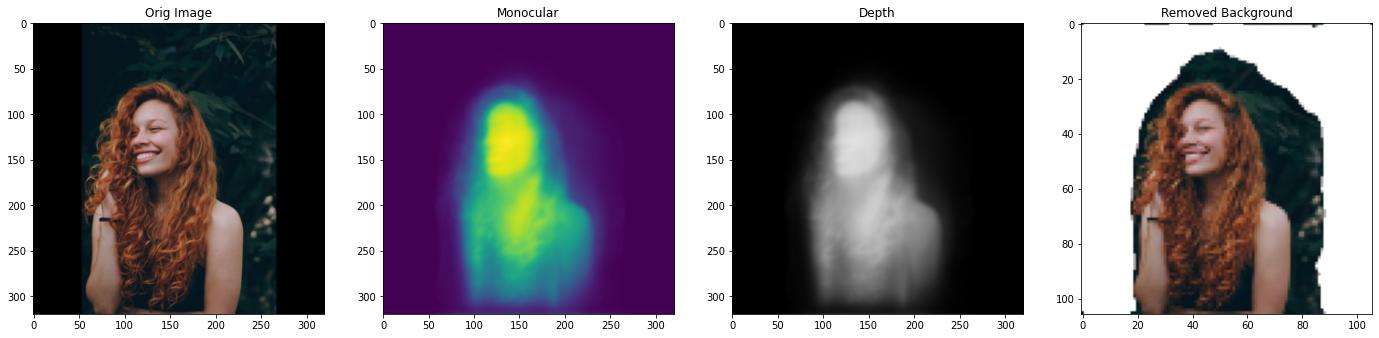

In [ ]:
def show_images(images,titles,cols = 1):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        # plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

show_images(arr,tittle)

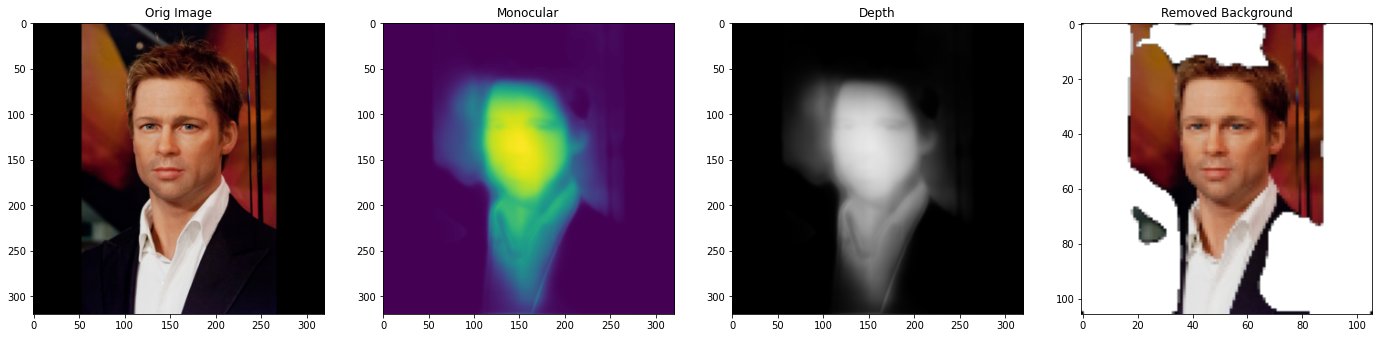

In [ ]:
show_images(arr,tittle)

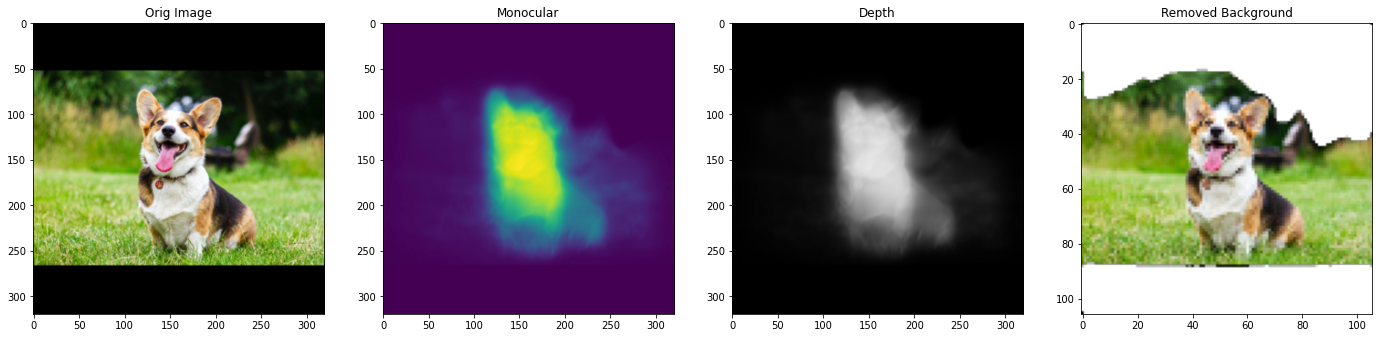

In [ ]:
show_images(arr,tittle)